<font color='green' size='7'>**Итоговая аттестация**</font>  
<font size='6' color='#11a642'>**Задание:**</font>  

Итоговая аттестация основана на конкурсе:  
[https://www.kaggle.com/competitions/playground-series-s5e7/overview](https://www.kaggle.com/competitions/playground-series-s5e7/overview).  

<font size='4' color='#11a642'>**Ваша задача:**</font> Построить модель с лучшими метриками.  
<font size='4' color='#11a642'>**Что можно использовать:**</font> Любые модели и методы обработки данных.  
<font size='4' color='#11a642'>**Сколько моделей нужно построить:**</font> Столько, сколько вы считаете достаточным для обоснования выбора наилучшей модели.  
<font size='4' color='#11a642'>**Важно:**</font> Каждый этап должен сопровождаться комментариями и выводами.  

<font size='4' color='green'>**Рекомендованные этапы:**</font>  
- Провести EDA.  
- Выявить и обработать проблемы в данных (если это улучшит метрики).  
- Построить несколько моделей с разными подходами.  
- Выбрать наилучшую модель.  
- *Опционально:* Участие в Kaggle (загрузить решение и указать позицию в leaderboard).  

На момент выдачи задания конкурс активен, поэтому у вас есть возможность не только выполнить учебную задачу, но и поучаствовать в соревновании.  

<font size='4' color='green'>**Форма сдачи:**</font>  
- Файл в формате `.ipynb` (Jupyter Notebook).  
- Перед загрузкой убедитесь, что ноутбук запускается без ошибок (`Kernel → Restart & Run All`).  

Удачи в выполнении задания!  

# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap

import xgboost as xgb

from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingClassifier

from optuna.integration import CatBoostPruningCallback
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, Dataset

import warnings
warnings.filterwarnings("ignore")

# Настройки отображения данных в Pandas
pd.set_option('display.max_columns', 50)  # Отображать до 50 столбцов
pd.set_option('display.precision', 5)  # Отображение ДФ с 5-ю знаками после запятой

In [2]:
# Зафиксируем сиды

SEED = 127
np.random.seed(SEED)
random.seed(SEED)

# <font color='#11a642' size='6'> Функции, собранные из разных ДЗ 🧠

In [3]:
def find_optimal_threshold(y_true, y_proba):
    """
    Подбор оптимального порога
    :param y_true: истинные метки классов
    :param y_proba: предсказанные вероятности классов
    :return: оптимальный порог
    """
    n_samples = len(y_true)  # количество наблюдений
    P = sum(y_true)  # количество истинных меток "1"
    N = n_samples - P  # количество истинных меток "0"
    # Функция для подбора оптимального порога
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # Вычисляем F1-score для каждого порога
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    # Находим порог с максимальным F1
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


def find_optimal_threshold_by_accuracy(y_true, y_proba):
    """
    Подбор оптимального порога по метрике accuracy.
    :param y_true: истинные метки классов (0 или 1)
    :param y_proba: предсказанные вероятности положительного класса
    :return: оптимальный порог
    """
    thresholds = np.linspace(0, 1, 10_000)  # пробуем 10_000 порогов от 0 до 1
    best_accuracy = 0
    best_threshold = 0.5  # по умолчанию

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        acc = accuracy_score(y_true, y_pred)
        if acc > best_accuracy:
            best_accuracy = acc
            best_threshold = threshold

    return best_threshold


def get_classification_metrics(y_true, y_pred, y_proba=None):
    """
    Расчёт метрик для бинарной классификации.
    :param y_true: Истинные метки (0 или 1)
    :param y_pred: предсказанные метки (0 или 1)
    :param y_proba: вероятности положительного класса (по желанию)
    :return: словарь с метриками
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
    }

    if y_proba is not None:
        # y_proba должен быть вероятностями положительного класса
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)

    return metrics


def train_valid_model(model_class, model_num, model_params, df_train, df_valid,
                      model_cols, target_col):
    """
    Процедура обучения и валидации модели
    :param model_class: Модель, которую используем для обучения
    :param model_num: Порядковый номер модели
    :param model_params: Параметры модели
    :param df_train: обучающий ДФ
    :param df_valid: валидационный ДФ
    :param model_cols: список признаков
    :param target_col: целевая переменная
    :return: обученная модель, ДФ с метриками
    """
    X_train, y_train = df_train[model_cols], df_train[target_col]
    X_valid, y_valid = df_valid[model_cols], df_valid[target_col]

    model = model_class(**model_params, random_state=SEED)

    model.fit(X_train, y_train)

    # Получение вероятностей
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_valid_proba = model.predict_proba(X_valid)[:, 1]

    # Подбираем порог на валидационной выборке
    optimal_threshold = find_optimal_threshold(y_valid, y_valid_proba)
    # optimal_threshold = find_optimal_threshold_by_accuracy(y_valid, y_valid_proba)
    print(f"Оптимальный порог: {optimal_threshold:.4f}")  # Оптимальный порог: 0.2336
    # Применяем порог к обеим выборкам
    y_train_pred = (y_train_proba >= optimal_threshold).astype(int)
    y_valid_pred = (y_valid_proba >= optimal_threshold).astype(int)

    metrics_train = get_classification_metrics(y_train, y_train_pred, y_train_proba)
    metrics_valid = get_classification_metrics(y_valid, y_valid_pred, y_valid_proba)

    metric_t = f'Train{model_num}'
    metric_v = f'Valid{model_num}'

    # Создаем DataFrame
    metrics = pd.DataFrame({'Metric': list(metrics_train.keys()),
                            metric_t: list(metrics_train.values()),
                            metric_v: list(metrics_valid.values())})

    # Добавляем разницу между train и valid (в %)
    metrics[f'Diff{model_num},%'] = ((metrics[metric_v] - metrics[metric_t])
                                     / metrics[metric_t] * 100).round(2)
    return model, metrics, optimal_threshold


def find_best_model(metrics_df):
    """
    Процедура поиска лучшей модели по метрикам
    :param metrics_df: ДФ с метриками
    :return: None
    """
    models = []
    for idx, row in metrics_df.iterrows():
        metric_name = row['Metric']

        # Отбираем только численные значения из колонок Valid*
        valid_cols = [col for col in metrics_df.columns if col.startswith('Valid')]
        valid_values = row[valid_cols]

        best_col = valid_values.idxmax()
        best_val = valid_values.max()

        models.append(best_col)

        print(f"Метрика: {metric_name:<10} --> лучшая модель: {best_col} ({best_val:.4f})")

    result = Counter(models).most_common()[0]
    print('\nЛучшая модель: {} на {} метриках из {}'.format(*result, len(models)))


def plot_feature_importance(model, feature_names, name_model='CatBoost', top_n=20):
    """
    Визуализация важности признаков модели.
    :param model: Обученная модель
    :param feature_names: Список признаков (в том же порядке, что использовались для обучения)
    :param name_model: Имя модели для заголовка    
    :param top_n: Сколько самых важных признаков отобразить
    """
    # Получаем важности признаков
    # importances = model.get_feature_importance()
    importances = model.feature_importances_

    # Создаём DataFrame
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).reset_index(drop=True)

    # Отрисовка
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(top_n), palette='viridis')
    plt.title(f'{name_model} — Топ {top_n} признаков по важности')
    plt.xlabel('Важность')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()
    return feat_imp_df  # возвращаем на всякий случай


def find_depth(model_class, model_params, train, valid, model_columns, target, depths=None):
    """
    Функция поиска оптимальной глубины деревьев
    :param model_class: Модель, которую используем для обучения
    :param model_params: Параметры модели
    :param train: обучающий ДФ
    :param valid: валидационный ДФ
    :param model_columns: список признаков
    :param target: целевая переменная
    :param depths: диапазон поиска глубины дерева
    :return: Оптимальная глубина дерева
    """
    if depths is None:
        depths = range(3, 21)

    train_f1, valid_f1 = [], []
    for depth in depths:

        model_params['max_depth'] = depth

        _, metrics, _ = train_valid_model(model_class, 0, model_params,
                                          train, valid, model_columns, target)

        # Получаем значения метрик
        t_f1, v_f1 = metrics[metrics['Metric'] == 'f1'][['Train0', 'Valid0']].values[0]
        train_f1.append(t_f1)
        valid_f1.append(v_f1)

        print(f"Depth: {depth:2} | Train F1: {t_f1:.5f} | Valid F1: {v_f1:.5f}")

        # Ранняя остановка, если текущий F1 < минимального найденного,
        # и минимум был хотя бы 2 шага назад
        max_valid_f1 = max(valid_f1)
        max_index = valid_f1.index(max_valid_f1)
        if len(valid_f1) > max_index + 2 and valid_f1[-1] < max_valid_f1:
            print(f"Ранняя остановка: лучший Valid F1 ({max_valid_f1:.5f}) "
                  f"был на глубине {depths[max_index]}")
            break

    plt.figure(figsize=(10, 6))
    plt.plot(depths[:len(train_f1)], train_f1, label='Train F1', marker='o')
    plt.plot(depths[:len(valid_f1)], valid_f1, label='Valid F1', marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('F1')
    plt.title('Зависимость F1 от глубины дерева')
    plt.legend()
    plt.grid(True)
    plt.show()

    return depths[max_index]


def make_submit(model, X_test, threshold, reverse_mapping):
    """
    Подготовка файла сабмита для загрузки на Каггл
    :param model: обученная модель
    :param X_test: подготовленные тестовые данные
    :param threshold: порог для классификации
    :param reverse_mapping: реверсный словарь целевой переменной
    :return: Имя файла сабмита
    """
    # Целевая переменная
    target = 'Personality'
    # Формируем имя файла
    file_submit = f'submit_{model.__class__.__name__}.csv'
    # Получаем предсказания
    y_test_proba = model.predict_proba(X_test)[:, 1]
    # Преобразуем вероятности в классы 0 / 1
    y_test_pred = (y_test_proba >= threshold).astype(int)
    # Записываем в датафрейм
    X_test[target] = y_test_pred
    # Возвращаем метки классов
    X_test[target] = X_test[target].map(reverse_mapping)
    # Сохраняем в файл
    X_test[target].to_csv(file_submit)
    print(f'Сформирован файл сабмита: {file_submit}')
    return file_submit


def set_types(df, num_cols, cat_cols):
    # Явно задаем типы
    for col in num_cols:
        df[col] = df[col].astype(int)
    for col in cat_cols:
        df[col] = df[col].astype('category')
    return df

# <font color='#11a642' size='6'> **Загрузка данных**

In [4]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
# Если удалось импортировать ydata_profiling - тогда смотрим красивый анализ данных

# try:
#     from ydata_profiling import ProfileReport
    
#     profile = ProfileReport(df, title="Profiling Report")
#     profile.to_notebook_iframe()
# except ModuleNotFoundError:
#     print('Не судьба посмотреть результаты ProfileReport 🧐')

In [6]:
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [7]:
# Колонка "id" не несет смысла - это индекс

df.set_index("id", inplace=True)
test.set_index("id", inplace=True)

# <font color='#11a642' size='6'> **Проверка на пропуски**

In [8]:
df.isna().sum() / len(df) * 100

Time_spent_Alone              6.42410
Stage_fear                   10.21918
Social_event_attendance       6.37011
Going_outside                 7.91406
Drained_after_socializing     6.20276
Friends_circle_size           5.68992
Post_frequency                6.82358
Personality                   0.00000
dtype: float64

In [9]:
test.isna().sum() / len(test) * 100

Time_spent_Alone             6.88259
Stage_fear                   9.68421
Social_event_attendance      6.42915
Going_outside                7.54656
Drained_after_socializing    6.99595
Friends_circle_size          5.66802
Post_frequency               6.60729
dtype: float64

### 👉 **Вывод:** Во всех признаках есть пропуски от 5 до 10 %, кроме целевой переменной. Будем смотреть на ститистики по признакам, чтобы понять как заполнять пропуски.

In [10]:
# Сколько строк и столбцов
df.shape

(18524, 8)

In [11]:
# Целевая переменная
target = 'Personality'

In [12]:
# Выбираем числовые признаки
num_cols = df.drop(columns=target).select_dtypes(include=['number']).columns.tolist()
# Считаем статистики
df[num_cols].agg(['min', 'max', 'mean', 'median']).T

,min,max,mean,median
Time_spent_Alone,0.0,11.0,3.13776,2.0
Social_event_attendance,0.0,10.0,5.26511,5.0
Going_outside,0.0,7.0,4.04432,4.0
Friends_circle_size,0.0,15.0,7.99674,8.0
Post_frequency,0.0,10.0,4.98210,5.0


In [13]:
# Выбираем категориальные колонки (включая строки и категории)
cat_cols = df.drop(columns=target).select_dtypes(include=['object', 'category']).columns.tolist()
# Считаем статистики
df[cat_cols].agg([lambda z: z.mode().tolist()[0], 'nunique']).T.rename(columns={'<lambda>': 'mode'})

,mode,nunique
Stage_fear,No,2
Drained_after_socializing,No,2


### 🧠 Для заполнения пропусков в данном датасете пробуем подход, учитывающий тип признаков и распределение данных:

### ✅ 1. **Числовые признаки** (Time_spent_Alone, Social_event_attendance, Going_outside, Friends_circle_size, Post_frequency)
- **Рекомендуемый метод: Заполнение медианой**  
  Причины:
  - Признаки имеют целочисленные значения (часы, дни, количество событий).
  - Распределения скошены (особенно `Time_spent_Alone`: mean=3.14, median=2.0), медиана устойчива к выбросам.
  - Для симметричных признаков (`Social_event_attendance`, `Friends_circle_size` и др.) медиана совпадает или близка к среднему, но предпочтительна из-за дискретной природы данных.

### ✅ 2. **Категориальные признаки** (Stage_fear, Drained_after_socializing)
- **Рекомендуемый метод: Заполнение модой (наиболее частой категорией)**  
  Причины:
  - Это бинарные признаки (Yes/No).
  - Заполнение модой сохраняет исходное распределение категорий без внесения новых значений.

### 💡 3. **Дополнительные рекомендации**
- **Проверка распределений**: Перед заполнением пропусков посмотреть распределения категориальных переменных. Если категории сбалансированы (50/50), мода может быть неочевидна, но всё равно применима.
- **Индикаторы пропусков**: Добавить бинарные признаки-индикаторы (например, `Stage_fear_missing`), особенно если пропуски могут быть информативны (например, люди с сильной боязнью сцены чаще пропускают ответ). Это улучшит качество будущих моделей.
- **KNNImputer для числовых данных**: Если есть корреляции между признаками (например, `Friends_circle_size` и `Social_event_attendance`), используем KNN-заполнение. 
  - **Плюсы**: Учитывает связи между переменными.
  - **Минусы**: Менее интерпретируем и требует нормализации данных.

### 📌 4. **Порядок действий**
1. Делим данные на train/valid, чтобы избежать утечки данных.
2. Добавляем индикаторы пропусков.
3. Для числовых признаков пропуски заполняем медианой.
4. Для категориальных признаков пропуски заполняем модой.

### 🛠️ Почему не другие методы?
- **Среднее значение**: Не подходит для `Time_spent_Alone` (разница между mean и median >50%), может исказить данные.
- **Предиктивные модели (Random Forest)**: Избыточны при 5-10% пропусков, но могут быть полезны при >20%.
- **Удаление строк**: Приемлемо только если пропуски <5%. Здесь потери данных составят 5-10%, что существенно.

👉 **Итог**: Используем **медиану для числовых** и **моду для категориальных** признаков как самый эффективный и интерпретируемый подход для данного датасета.

# <font color='#11a642' size='6'> **Поиск и анализ выбросов**

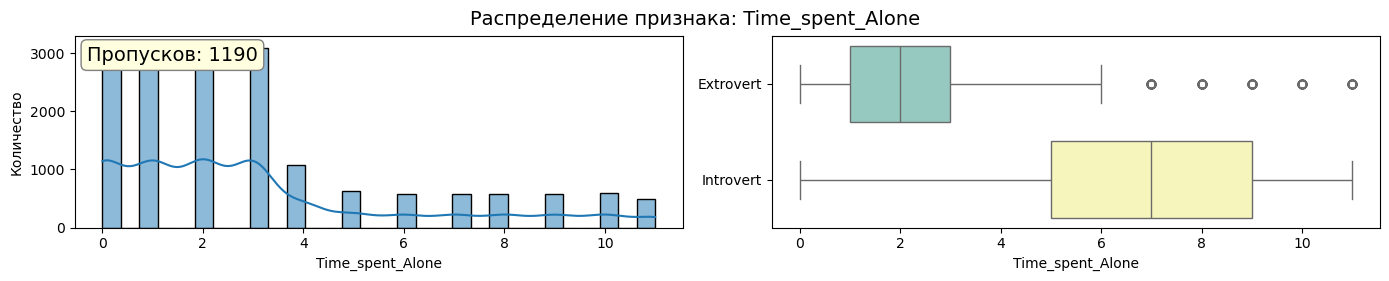

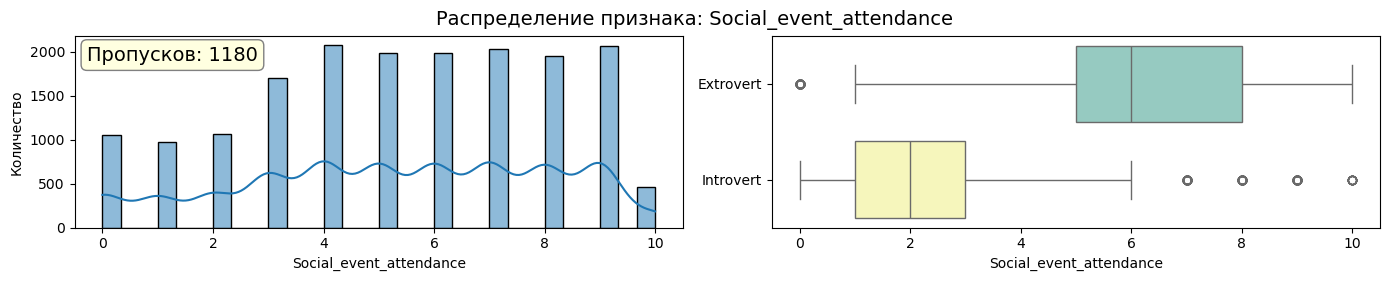

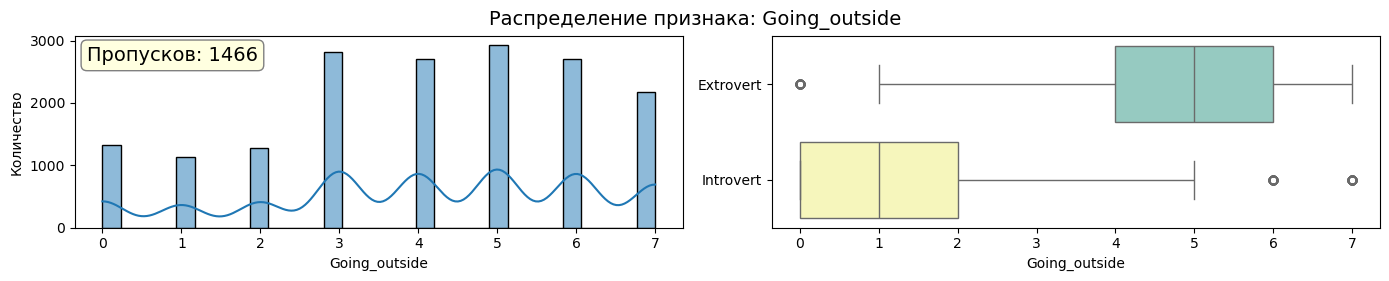

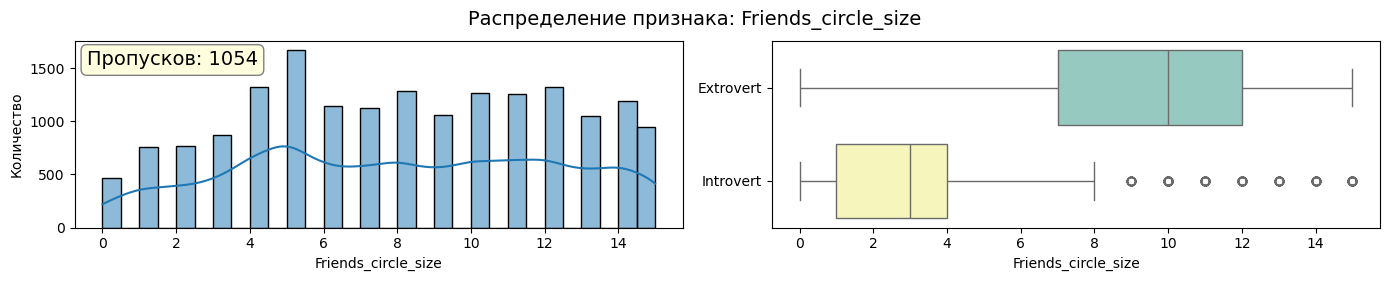

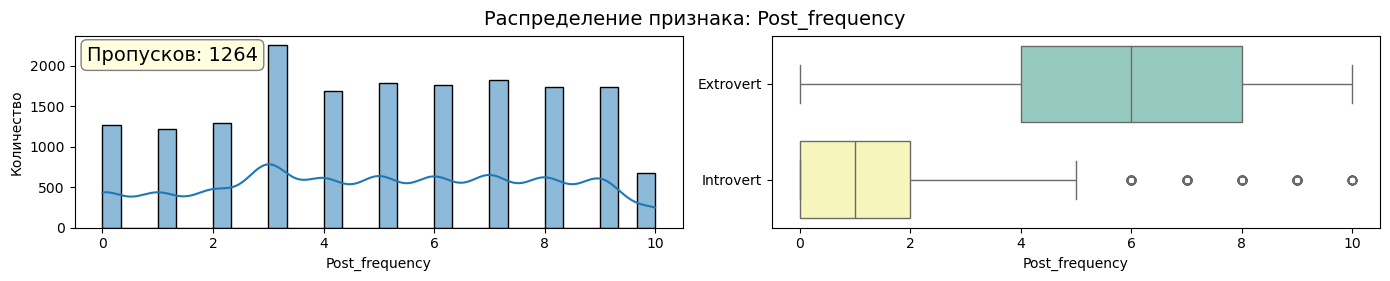

In [14]:
# Распределения числовых признаков

for feature in num_cols:
    plt.figure(figsize=(14, 3))
    plt.suptitle(f"Распределение признака: {feature}", fontsize=14, y=0.92)

    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.xlabel(feature)
    plt.ylabel("Количество")
    
    plt.text(0.02, 0.95,
             f"Пропусков: {df[feature].isnull().sum()}",
             ha='left', va='top',
             transform=plt.gca().transAxes,
             fontsize=14,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='gray')
            )

    # Распределение признака в разрезе целевой переменной
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[target], x=df[feature], palette='Set3')
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# 🔍 <font color='#11a642' size='5'>  Анализ  **гистограмм** и **boxplot-графиков** по числовым признакам:

---

### 📌 1. **Time\_spent\_Alone** (Время, проведённое в одиночестве)

* **Интроверты** в среднем проводят **значительно больше времени в одиночестве** — медиана около 8 часов.
* **Экстраверты** — около 2 часов в среднем.
* Распределения не пересекаются полностью: это может быть **сильный дифференцирующий признак**.

📈 **Вывод:** Чем больше человек проводит времени один, тем выше вероятность, что он интроверт.

---

### 📌 2. **Social\_event\_attendance** (Частота посещения социальных мероприятий)

* **Экстраверты** посещают **значительно больше мероприятий в месяц** — медиана около 6–7.
* **Интроверты** — медиана около 2.
* Распределения частично пересекаются, но экстраверты заметно активнее.

📈 **Вывод:** Экстраверты чаще посещают мероприятия, что логично — они получают энергию от общения.

---

### 📌 3. **Going\_outside** (Дни в неделю, когда выходит из дома)

* **Экстраверты** — медиана около 5 дней в неделю.
* **Интроверты** — медиана около 2 дней.
* Явное отличие: экстраверты чаще выходят на улицу.

📈 **Вывод:** Интроверты чаще остаются дома, экстраверты более активны вне дома.

---

### 📌 4. **Friends\_circle\_size** (Размер круга близких друзей)

* **Экстраверты** — медиана около 10–11 друзей.
* **Интроверты** — около 3–4.
* Сильное различие, много выбросов у экстравертов (возможно, 15+ друзей).

📈 **Вывод:** Экстраверты имеют больший круг общения.

---

### 📌 5. **Post\_frequency** (Частота публикаций в соцсетях)

* **Экстраверты** постят в среднем 6–8 раз в месяц.
* **Интроверты** — около 2.
* Опять же, экстраверты более активны в публичной онлайн-среде.

📈 **Вывод:** Постинг в соцсетях отражает внешнюю активность, характерную для экстравертов.

---

## 🧠 Общая интерпретация:

Все числовые признаки, представленные на графиках, **сильно различаются между интровертами и экстравертами**. Причем отличия логично соответствуют психологическим характеристикам:

| Признак                   | Характеристика интровертов | Характеристика экстравертов |
| ------------------------- | -------------------------- | --------------------------- |
| `Time_spent_Alone`        | Много времени одни         | Мало времени одни           |
| `Social_event_attendance` | Редко ходят на мероприятия | Часто посещают              |
| `Going_outside`           | Мало выходов               | Часто выходят               |
| `Friends_circle_size`     | Мало друзей                | Много друзей                |
| `Post_frequency`          | Реже постят                | Часто постят                |

🔍 Это позволяет предположить, что модель классификации по этим признакам сможет **эффективно различать** типы личности.

# 🔍 <font color='#11a642' size='5'> Анализ **boxplot-графиков** на выбросы
Выбросы **явно присутствуют**. Они обозначены как **отдельные кружки** за пределами «усов» (границ IQR ± 1.5 × IQR). Ниже — анализ по каждому признаку:

---

### 🔹 **1. `Time_spent_Alone`**

* **У интровертов** есть **много выбросов** в правой части (значения выше 10 часов в день).
* **У экстравертов** выбросов меньше, но несколько точек выше 6–7 часов тоже выходят за пределы усов.

👉 **Да, выбросы присутствуют у обеих групп**, особенно у интровертов.

---

### 🔹 **2. `Social_event_attendance`**

* У **экстравертов** — **несколько выбросов справа** (более 9 мероприятий в месяц).
* У **интровертов** — выбросы **с обеих сторон** (в том числе ноль и >6).

👉 **Да, есть выбросы**, но умеренные по количеству.

---

### 🔹 **3. `Going_outside`**

* У **экстравертов** — выбросы справа (6–7 дней в неделю — это максимум).
* У **интровертов** — выбросов нет, данные более компактные.

👉 **Небольшое количество выбросов** у экстравертов.

---

### 🔹 **4. `Friends_circle_size`**

* У **обоих классов** есть **ярко выраженные выбросы**, особенно у экстравертов (размер круга 13–15 друзей).
* У интровертов — выбросы в районе 8+ друзей.

👉 **Да, это один из признаков с наибольшим количеством выбросов**.

---

### 🔹 **5. `Post_frequency`**

* У **экстравертов** — **большое количество выбросов**, например, 10 постов в месяц.
* У **интровертов** — выбросы ближе к 6–8 постам.

👉 **Выбросы есть в обеих группах**, экстраверты более разнообразны по активности.

---

## 🧾 Итог:

| Признак                   | Выбросы?   | Где больше? |
| ------------------------- | ---------- | ----------- |
| Time\_spent\_Alone        | ✅ Да       | Интроверты  |
| Social\_event\_attendance | ✅ Да       | Обе группы  |
| Going\_outside            | ✅ Умеренно | Экстраверты |
| Friends\_circle\_size     | ✅ Много    | Экстраверты |
| Post\_frequency           | ✅ Много    | Экстраверты |

### 🧠 Вывод:

Выбросы **присутствуют практически во всех признаках** и особенно характерны для экстравертов, так как их поведение более вариативно. Это **нормально для поведенческих данных**. Но:

* при моделировании стоит протестировать модели **с и без выбросов**,
* можно использовать **робастные метрики** (например, медиану, IQR),
* при необходимости — применить **винзоризацию** или **обрезку по перцентилям** (например, \[1%, 99%]).

### 📐 Анализ влияния выбросов на среднее и стандартное отклонение

Сравним средние и стандартные отклонения до и после удаления выбросов (по правилу 1.5 * IQR):

In [15]:
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    mask = (data[col] >= Q1 - 1.5 * IQR) & (data[col] <= Q3 + 1.5 * IQR)
    return data[mask]

for col in num_cols:
    original_mean = df[col].mean()
    original_std = df[col].std()

    cleaned_df = remove_outliers_iqr(df, col)
    cleaned_mean = cleaned_df[col].mean()
    cleaned_std = cleaned_df[col].std()

    print(f"📌 {col}")
    print(f"  ➤ Среднее до очистки: {original_mean:.2f}, после: {cleaned_mean:.2f}")
    print(f"  ➤ Стд. отклонение до: {original_std:.2f}, после: {cleaned_std:.2f}")
    print("-" * 42)

📌 Time_spent_Alone
  ➤ Среднее до очистки: 3.14, после: 2.42
  ➤ Стд. отклонение до: 3.00, после: 2.12
------------------------------------------
📌 Social_event_attendance
  ➤ Среднее до очистки: 5.27, после: 5.27
  ➤ Стд. отклонение до: 2.75, после: 2.75
------------------------------------------
📌 Going_outside
  ➤ Среднее до очистки: 4.04, после: 4.04
  ➤ Стд. отклонение до: 2.06, после: 2.06
------------------------------------------
📌 Friends_circle_size
  ➤ Среднее до очистки: 8.00, после: 8.00
  ➤ Стд. отклонение до: 4.22, после: 4.22
------------------------------------------
📌 Post_frequency
  ➤ Среднее до очистки: 4.98, после: 4.98
  ➤ Стд. отклонение до: 2.88, после: 2.88
------------------------------------------


### 🧹 Попробуем удалить выбросы по всем признакам

In [16]:
cleaned_df = df.copy()
for col in num_cols:
    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    mask = (cleaned_df[col] >= Q1 - 2 * IQR) & (cleaned_df[col] <= Q3 + 2 * IQR)
    cleaned_df = cleaned_df[mask]

print(f"📉 Размер до очистки: {df.shape}, после: {cleaned_df.shape}")

📉 Размер до очистки: (18524, 8), после: (12514, 8)


## ⚠️ **Удалено около 32% данных (6010 из 18524)**. 
Это **сигнал, что стратегия удаления выбросов по 1.5×IQR для *каждого* признака слишком агрессивна**, особенно при последовательной фильтрации по нескольким колонкам.

---

## 🔍 Почему почти не изменились средние и стандартные отклонения до и после удаления выбросов (кроме `Time_spent_Alone`)?

| Признак                   | Среднее / std изменились? | Причина                                                                         |
| ------------------------- | ------------------------- | ------------------------------------------------------------------------------- |
| **Time\_spent\_Alone**    | ✅ Да                      | Было **много выбросов справа** (10–12 ч/день), они сильно тянули среднее вверх. |
| Social\_event\_attendance | ❌ Нет                     | Распределение более «компактное», без сильных выбросов.                         |
| Going\_outside            | ❌ Нет                     | Ограничено сверху (макс. 7 дней), выбросов почти нет.                           |
| Friends\_circle\_size     | ❌ Нет                     | Широкое распределение — но выбросы «нормальные» по смыслу.                      |
| Post\_frequency           | ❌ Нет                     | Верхние значения ≈ 10 — допустимы, не считаются шумом.                          |

---

## ✅ Что можно сделать вместо жесткой фильтрации?

### 🔸 1. **Мягкая обрезка — винзоризация (Winsorization)**

Ограничиваем значения на разумном уровне (например, 1 и 99 перцентили), **не удаляя строки**.

```python
def winsorize_series(s, lower=0.01, upper=0.99):
    return s.clip(lower=s.quantile(lower), upper=s.quantile(upper))

for col in num_cols:
    df[f'{col}_winsorized'] = winsorize_series(df[col])
```

➡️ Это сохранит все строки, но уберёт влияние экстремальных значений.

---

### 🔸 2. **Очистка только по ключевым признакам**

В нашем случае, **только `Time_spent_Alone` реально искажает метрику**:

```python
df_clean = df[remove_outliers_iqr(df, 'Time_spent_Alone').index]
print(df_clean.shape)
```

---

### 🔸 3. **Использовать робастные методы обучения**:

Т.к. у нас классификация, то модели типа:

* `LogisticRegression(penalty='l1')`
* `HistGradientBoostingClassifier`
* или `CatBoost` / `XGBoost` с `loss='MAE'`
  — **меньше страдают от выбросов**, чем линейные регрессии по MSE.

---

## 💬 Резюме:

| Стратегия           | Что делает                              | Подходит, если                    |
| ------------------- | --------------------------------------- | --------------------------------- |
| `drop by IQR`       | Удаляет строки с экстремумами           | Небольшой датасет, важна точность |
| `winsorization`     | Обрезает значения без удаления строк    | Нужно сохранить максимум данных   |
| `робастные модели`  | Устойчивы к выбросам                    | Планируется обучение ML-модели    |
| `локальная очистка` | Удаляет выбросы только по 1–2 признакам | Выбросы явно портят метрики       |


# 🔍 <font color='#11a642' size='5'> Распределения категориальных признаков

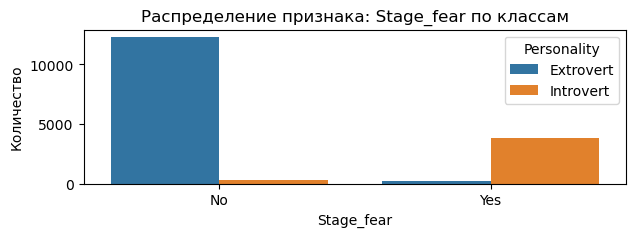

,Stage_fear,proportion
0,No,0.75816
1,Yes,0.24184


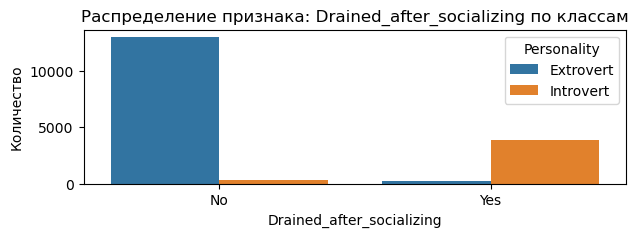

,Drained_after_socializing,proportion
0,No,0.76622
1,Yes,0.23378


In [17]:
for col in cat_cols:
    plt.figure(figsize=(7,2))
    plt.title(f"Распределение признака: {col} по классам", fontsize=12)
    sns.countplot(data=df, x=col, hue=target)
    plt.ylabel("Количество")
    plt.show()
    # Посмомтрим в цифрах
    display(pd.DataFrame(df[col].value_counts(normalize=True)).reset_index())

## 🔍 Анализ категориальных признаков: 
с учётом **распределения по типу личности (Introvert / Extrovert)**.

---

## 📌 `Stage_fear` — Страх публичных выступлений

### 🔍 **Общие пропорции:**

| Значение | Описание   | Пропорция |
| -------- | ---------- | --------- |
| No       | Нет страха | 75.8%     |
| Yes      | Есть страх | 24.2%     |

### 📊 **По типу личности:**

* Среди тех, у кого **нет страха** — подавляющее большинство **экстравертов**.
* Среди тех, у кого **есть страх** — **преобладают интроверты**.

### 📈 **Интерпретация:**

* Экстраверты **чаще уверены в публичных выступлениях**.
* Интроверты **значительно чаще испытывают страх сцены**.

🔎 Этот признак **сильно коррелирует с интроверсией/экстраверсией**.

---

## 📌 `Drained_after_socializing` — Истощение после общения

### 🔍 **Общие пропорции:**

| Значение | Описание  | Пропорция |
| -------- | --------- | --------- |
| No       | Не устаёт | 76.6%     |
| Yes      | Устаёт    | 23.4%     |

### 📊 **По типу личности:**

* Среди тех, кто **не устаёт после общения** — почти все **экстраверты**.
* Среди тех, кто **испытывает усталость** — **значительное количество интровертов**.

### 📈 **Интерпретация:**

* Экстраверты **восполняют энергию** через социальные контакты.
* Интроверты, наоборот, **теряют энергию**, что соответствует психологической теории интроверсии.

---

## 🧠 Обобщение по категориальным признакам:

| Признак                           | Связан с...            | Характерен для интровертов |
| --------------------------------- | ---------------------- | -------------------------- |
| `Stage_fear = Yes`                | Социальная тревожность | ✅ Да                       |
| `Drained_after_socializing = Yes` | Энергетические затраты | ✅ Да                       |

---

## ✅ Вывод:

Оба категориальных признака:

* **логично и сильно различаются между типами личности**,
* имеют высокую **объяснительную силу** и должны быть включены в модель предсказания типа личности.

# 🔍 <font color='#11a642' size='5'> Распределение целевой переменной

In [18]:
pd.DataFrame(df[target].value_counts(normalize=True)).reset_index()

,Personality,proportion
0,Extrovert,0.73953
1,Introvert,0.26047


## 👉 **В целевой переменной `Personality` присутствует дисбаланс классов:**
- **Экстраверты (Extrovert):** 73.95% 
- **Интроверты (Introvert):** 26.05%

**Соотношение классов:**  
Приблизительно **2.84:1** (экстравертов почти в 3 раза больше, чем интровертов).

---

### 🔍 Почему это проблема?
1. **Смещение модели:** Алгоритмы машинного обучения склонны лучше предсказывать доминирующий класс (экстраверты).
2. **Низкое качество для миноритарного класса:** Модель может "игнорировать" интровертов, что приведет к:
   - Высокой **ложноотрицательной ошибке** (интроверты ошибочно классифицируются как экстраверты).
   - Низкому **recall** для класса `Introvert`.

---

### 📊 Рекомендации по обработке дисбаланса:
#### 1. **Методы взвешивания (Weighting):**
   - Добавить **class_weight='balanced'** в модели 
   - **Преимущество:** Не меняет данные, только штрафует ошибки для миноритарного класса.

#### 2. **Сэмплирование данных:**
   - **Oversampling миноритарного класса (интроверты):**
     ```python
     from imblearn.over_sampling import SMOTE
     smote = SMOTE(random_state=42)
     X_res, y_res = smote.fit_resample(X_train, y_train)
     ```
   - **Undersampling мажоритарного класса (экстраверты):**
     ```python
     from imblearn.under_sampling import RandomUnderSampler
     rus = RandomUnderSampler(random_state=42)
     X_res, y_res = rus.fit_resample(X_train, y_train)
     ```
   - **Комбинированный подход (SMOTE + Undersampling).**

#### 3. **Выбор метрик для оценки:**
   Избегать **accuracy** (для соревнования Kaggle выбрал именно Accuracy Score), использовать:
   - **F1-score** (среднее гармоническое precision и recall),
   - **Precision-Recall AUC**,
   - **Матрица ошибок (Confusion Matrix)**,
   - **Отчет по классам (classification_report)**.

#### 4. **Ансамблевые методы:**
   - Использовать Модели, устойчивые к дисбалансу классов.

---

### ⚠️ Важно:
- **Стратифицированное разбиение:** При разделении на train/test использовать `stratify=y`, чтобы сохранить пропорции.
- **Проверка влияния на бизнес-задачу:** Уточните, какой класс критичнее предсказывать точно (например, если стоимость ошибки для интровертов выше, нужен акцент на recall).

## 👉 **Вывод:** Дисбаланс требует коррекции на этапе обучения модели, иначе результаты прогноза для интровертов будут ненадежными.

# <font color='#11a642' size='4'> **Перед построение матрицы корреляции закодируем категориальные переменные:**
- Категориальные переменные имеют 2 значения, не будем заморачиваться с пайплайном: руками быстрее

In [19]:
# Исходный словарь кодирования целевой переменной
mapping_target = {'Extrovert': 0, 'Introvert': 1}
# Создание реверсного словаря
reverse_mapping = {v: k for k, v in mapping_target.items()}

df_tmp = df.copy()

mapping_yes_no = {'Yes': 1, 'No': 0}
for col in cat_cols:
    df_tmp[col] = df_tmp[col].map(mapping_yes_no)

# Закодируем целевую переменную
df_tmp[target] = df_tmp[target].map(mapping_target)        

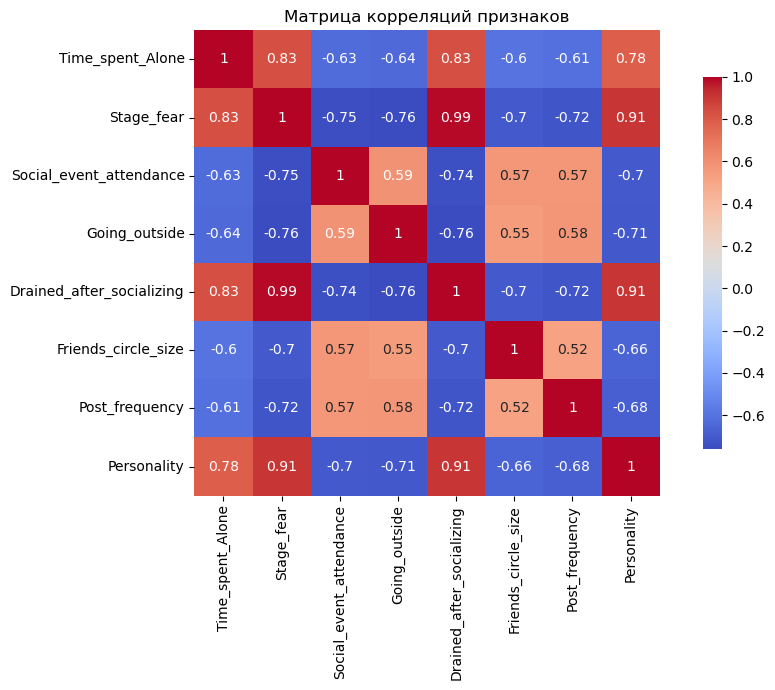

In [20]:
# Матрица корреляций
corr_matrix = np.round(df_tmp.corr(), 2)
# Зунулим значения не большой корреляции
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Матрица корреляций признаков")
plt.tight_layout()
plt.show()

## 🔍 Анализ матрицы корреляции с целевой переменной `Personality`:

1. **Сильнейшие предикторы личности** (корреляция > 0.9):
   - `Stage_fear`: **0.91**  
   - `Drained_after_socializing`: **0.91**  
   **Вывод**: Страх сцены и усталость после общения — ключевые индикаторы интроверсии. Почти линейная зависимость.

2. **Сильные предикторы** (корреляция 0.7-0.8):
   - `Time_spent_Alone`: **0.78**  
   - `Going_outside`: **-0.71**  
   **Инсайт**: Чем больше времени человек проводит в одиночестве и реже выходит из дома, тем выше вероятность интроверсии.

3. **Умеренные предикторы** (корреляция 0.6-0.7):
   - `Social_event_attendance`: **-0.70**  
   - `Friends_circle_size`: **-0.66**  
   - `Post_frequency`: **-0.68**  
   **Тенденция**: Экстраверты чаще посещают мероприятия, имеют больше друзей и активнее в соцсетях.

4. **Заполнить пропуски KNNImputer**
   - Этому поможет сильная корреляция между признаками.

---

### ⚠️ Критические проблемы данных:

1. **Экстремальная мультиколлинеарность**:  
   - `Stage_fear` и `Drained_after_socializing` коррелируют на **0.99** — **фактически дублирующие признаки**.  
   - `Stage_fear` также сильно коррелирует с `Time_spent_Alone` (**0.83**) и `Going_outside` (**-0.76**).  

2. **Риск переобучения**:  
   Высокая корреляция предикторов с целевой переменной (>0.9) может привести к:  
   - Искусственному завышению точности модели  
   - Плохой обобщающей способности на новых данных  

---

### 🔧 Рекомендации для моделирования:

1. **Удалить дублирующие признаки**:  
   Исключить `Drained_after_socializing` (т.к. он почти идентичен `Stage_fear`):

2. **Проверить VIF (фактор инфляции дисперсии)** для оставшихся признаков:  
   ```python
   from statsmodels.stats.outliers_influence import variance_inflation_factor
   
   vif_data = pd.DataFrame()
   vif_data["feature"] = X.columns
   vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
   
   ```
   При VIF > 5 — признаки требуют преобразования/удаления.

3. **Методы борьбы с мультиколлинеарностью**:  
   - **PCA** для уменьшения размерности  
   - **Регуляризация** (L1/L2 в логистической регрессии)  
   - **Деревья решений** (Random Forest, Gradient Boosting), устойчивые к корреляциям  

4. **Фокус на интерпретируемости**:  
   Если цель — предсказать факторы личности:  
   - Оставить только ключевые некоррелирующие предикторы:  
     `Time_spent_Alone`, `Friends_circle_size`, `Post_frequency`  
   - Удалить `Stage_fear` (из-за сверхвысокой корреляции с другими признаками)

---

### 📊 Прогноз для модели:
- **Без обработки**: В модели возможно будут перевешивать признаки `Stage_fear` и `Drained...`, игнорируя другие факторы.  
- **После обработки**: Более сбалансированное выявление паттернов, особенно для экстравертов (где признаки слабее коррелируют).
- **Baseline**:
  - Признаки оставляем как есть.
  - Числовые переменные: пропуски заполняем медианой и нормализуем.
  - Категориальные переменные: пропуски заполняем модой и кодируем.
  - Делим на train / valid со стратификацией.
  - Пробуем **LogisticRegression**.

> **Итог**: Данные идеально подходят для предсказания интроверсии, но требуют обработки мультиколлинеарности.

# <font color='#11a642' size='6'> **Разделим данные на трейн и тест**

In [21]:
df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...
18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert


In [22]:
# Закодируем целевую переменную
df[target] = df[target].map(mapping_target) 

In [23]:
# Колонки для моделей
model_columns = num_cols + cat_cols

# Разделение признаков и целевой переменной
X = df[model_columns]
y = df[target]

# Т.к. у нас наблюдается дисбаланс классов: класс с меткой "1" всего 26%
# Будем делить со стратификацией


train, valid, X_train, X_valid, y_train, y_valid = train_test_split(df, X, y,
                                                                    test_size=0.2, 
                                                                    stratify=y, 
                                                                    random_state=SEED)

# <font color='#11a642' size='6'> **Построение Baseline с помощью pipeline**

In [24]:
# Категориальный пайплайн с заполнением пропусков модой
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# Числовой пайплайн с заполнением пропусков медианой
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропусков медианой
    ('scaler', StandardScaler())
])

# Объединяем в ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, num_cols)
])

In [25]:
# Применяем трансформации
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

# Получаем имена признаков
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
all_feature_names = num_cols + list(cat_feature_names)

# Преобразуем в DataFrame
train_df = pd.DataFrame(X_train_processed, columns=all_feature_names, index=X_train.index)
valid_df = pd.DataFrame(X_valid_processed, columns=all_feature_names, index=X_valid.index)
# Добавим в ДФ целевую переменную, для использования в функции обучения
train_df[target] = y_train
valid_df[target] = y_valid

In [26]:
# Обучение логистической регрессии

params = {}
log_reg, metrics_lr, optimal_threshold = train_valid_model(LogisticRegression, 'LogReg',
                                                           params, train_df, valid_df,
                                                           all_feature_names, target)
metrics_df = metrics_lr.copy()
metrics_df

Оптимальный порог: 0.2336


,Metric,TrainLogReg,ValidLogReg,"DiffLogReg,%"
0,accuracy,0.96896,0.96923,0.03
1,precision,0.94179,0.94837,0.70
2,recall,0.93886,0.93264,-0.66
3,f1,0.94032,0.94044,0.01
4,roc_auc,0.95670,0.95577,-0.10


---

## 📊 Таблица метрик:

| Метрика   | Train   | Valid   | Разница (%) | Комментарий                                                                           |
| --------- | ------- | ------- | ----------- | ------------------------------------------------------------------------------------- |
| accuracy  | 0.96896 | 0.96923 | +0.03       | **Очень высокая** точность, совпадение train/valid говорит об отсутствии переобучения |
| precision | 0.94179 | 0.94837 | +0.70       | Модель **даёт очень мало ложных срабатываний** на "1"                                 |
| recall    | 0.93886 | 0.93264 | -0.66       | Немного ниже recall на валидации — но **в пределах нормы**                            |
| f1        | 0.94032 | 0.94044 | +0.01       | Идеальный баланс между precision и recall                                             |
| roc\_auc  | 0.95670 | 0.95577 | -0.10       | Очень высокая площадь под ROC, почти идентичная между выборками                       |

---

## 🧠 Интерпретация:

✅ **Модель стабильна**: Все метрики на `train` и `valid` очень близки (разница < 1%), что говорит:

* об отсутствии **overfitting**,
* об отсутствии **data leakage**,
* об **устойчивости** модели к новому unseen data.

✅ **Высокое качество**:

* Accuracy ≈ 97% — означает, что 97 из 100 объектов классифицируются правильно.
* F1 ≈ 0.94 — хорошо сбалансированная модель.
* ROC AUC ≈ 0.956 — отличная способность различать классы на основе вероятностей.

---
## 🟢 Вывод:

Модель логистической регрессии показала **высокое качество классификации** и **отличную обобщающую способность**. Она уже готова к продакшн или может быть использована как **baseline** для более сложных моделей (например, для бустингов).

## ✅ Построение важности признаков

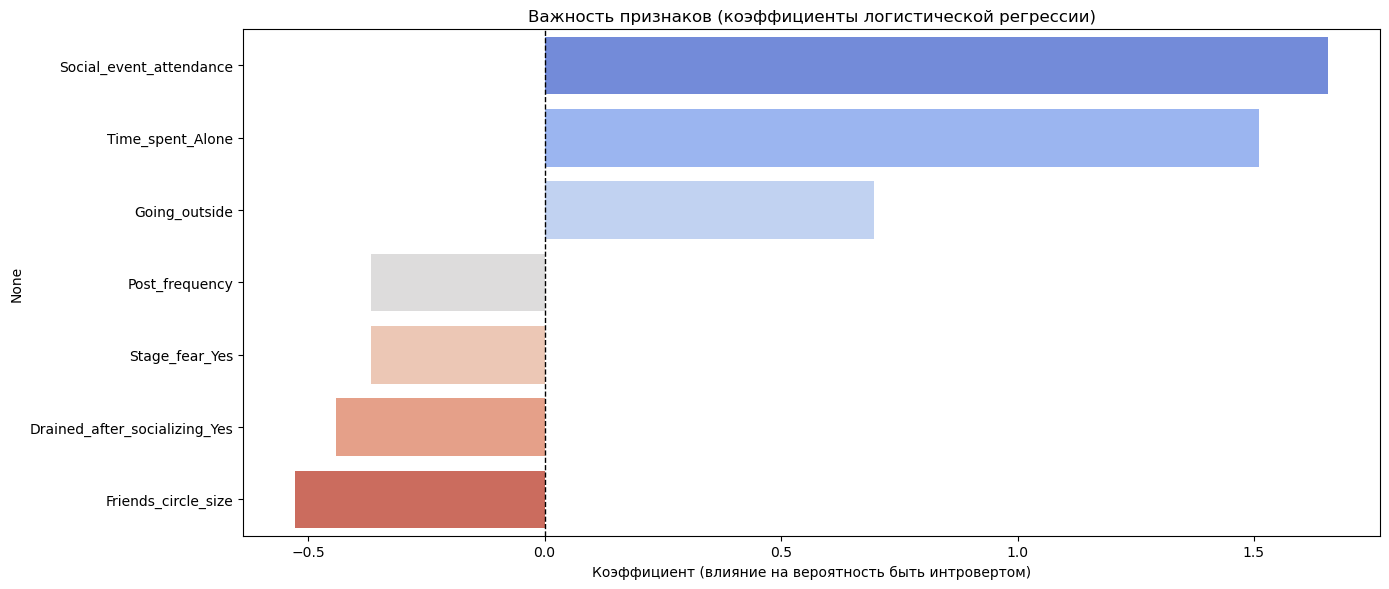

In [27]:
pd.Series(log_reg.coef_[0], index=all_feature_names).sort_values(ascending=False)

# Получаем важности (веса) признаков
coef_series = pd.Series(log_reg.coef_[0], index=all_feature_names).sort_values(ascending=False)

# Построение горизонтального barplot
plt.figure(figsize=(14, 6))
sns.barplot(x=coef_series.values, y=coef_series.index, palette='coolwarm')
plt.title('Важность признаков (коэффициенты логистической регрессии)')
plt.xlabel('Коэффициент (влияние на вероятность быть интровертом)')
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.tight_layout()
plt.show()

## ✅ Что это означает:

* **Коэффициенты логистической регрессии (`model.coef_`) показывают вклад каждого признака в увеличение вероятности быть интровертом.**
* То есть:

  * **Положительный коэффициент** ⟶ признак **повышает** вероятность класса `1` → **Introvert**.
  * **Отрицательный коэффициент** ⟶ признак **повышает** вероятность класса `0` → **Extrovert**.

---

## 📌 Таблица коэффициентов читается так:

| Признак                         | Коэфф. | Интерпретация (чем больше → тем более **интроверт**)            |
| ------------------------------- | ------ | --------------------------------------------------------------- |
| `Social_event_attendance`       | +1.66  | ⚠️ **Нелогично** — обычно экстраверты чаще ходят на мероприятия |
| `Time_spent_Alone`              | +1.51  | ✅ Чем больше времени один — тем более интроверт                 |
| `Going_outside`                 | +0.70  | ⚠️ Часто выходит — скорее экстраверт                            |
| `Post_frequency`                | −0.37  | ✅ Часто постит — скорее экстраверт                              |
| `Stage_fear_Yes`                | −0.37  | ❌ Страх сцены → должен был быть признаком интроверта            |
| `Drained_after_socializing_Yes` | −0.44  | ❌ Усталость после общения → должен был быть за интроверта       |
| `Friends_circle_size`           | −0.53  | ✅ Много друзей → экстраверт                                     |

---

## ❗ Противоречие:

* Некоторые признаки, которые **интуитивно должны указывать на интровертов**, имеют **отрицательный коэффициент**.
* Например:

  * `Drained_after_socializing_Yes` → должен **увеличивать** вероятность `Introvert`, а не уменьшать.
  * `Stage_fear_Yes` — то же самое.

---

## 🔍 Возможные причины:

1. **Сильная мультиколлинеарность** (признаки коррелируют между собой).
2. **Нестандартизованные признаки**, и веса неадекватны по масштабу.
3. **Переобучение или несбалансированность данных**.
4. **Ошибки в кодировке признаков (например, в OneHot для `Yes`/`No`)** — возможно, закодировалось не `'Yes' = 1`, а наоборот.
---

Отлично! Эта матрица корреляций — **ключ к разгадке аномалий в логистической регрессии**. Давайте разберём, что она показывает и почему некоторые коэффициенты в модели выглядят «неправильно».

---

## 🔍 Ключевые наблюдения по матрице корреляций:

### 1. **Stage\_fear** и **Drained\_after\_socializing**:

| Пара                                       | Корреляция    |
| ------------------------------------------ | ------------- |
| `Stage_fear` ↔ `Drained_after_socializing` | **+0.99** (!) |

🔴 Это **почти полная мультиколлинеарность** — признаки практически дублируют друг друга.

➡️ В модели логистической регрессии это вызывает **перераспределение весов**: один признак может получить "неправильный" знак, даже если коррелирует с целевой переменной верно.
---

### 2. Корреляции с целевой переменной (`Personality = 1 → Introvert`):

| Признак                     | Корреляция с `Personality` | Интерпретация                      |
| --------------------------- | -------------------------- | ---------------------------------- |
| `Stage_fear`                | **+0.91**                  | Очень сильный признак интроверта   |
| `Drained_after_socializing` | **+0.91**                  | То же самое                        |
| `Time_spent_Alone`          | +0.78                      | Сильный признак интроверта         |
| `Going_outside`             | −0.71                      | Меньше гуляет → интроверт          |
| `Social_event_attendance`   | −0.70                      | Меньше ходит на ивенты → интроверт |
| `Post_frequency`            | −0.68                      | Меньше постит → интроверт          |
| `Friends_circle_size`       | −0.66                      | Меньше друзей → интроверт          |

🔵 Всё логично, **связи с целевой переменной корректны**.

---

## ❗ Почему некоторые признаки в модели "вышли с неожиданным знаком"?

### Пример:

* `Drained_after_socializing` в регрессии имеет **отрицательный коэффициент**, но коррелирует с `Personality` на **+0.91**.

👉 Это симптом **мультиколлинеарности** — когда два (или более) признака настолько скоррелированы, что модель не может "решить", кому из них приписать влияние. В результате:

* **знаки коэффициентов искажаются**,
* **модель становится плохо интерпретируемой**.

---

## ✅ Что можно сделать:

### 🔸 Вариант 1: Удалить один из дублирующих признаков

Например, оставить только `Stage_fear`, а `Drained_after_socializing` убрать.
Это снимет коллинеарность и стабилизирует коэффициенты.
---

### 🔸 Вариант 2: Использовать регуляризацию (`penalty='l2'`)

Логистическая регрессия с регуляризацией сгладит веса:

```python
model = LogisticRegression(penalty='l2', solver='liblinear')
```
---

### 🔸 Вариант 3: Перейти на деревья (`CatBoost`, `RandomForest`)

Модели на основе деревьев **не страдают от мультиколлинеарности**, а также:

* автоматически обрабатывают категориальные признаки,
* дают интерпретируемую важность фичей (Feature Importance),
* не требуют стандартизации.
---

## 🧠 Вывод:

| Проблема                   | Причина                                     | Решение                       |
| -------------------------- | ------------------------------------------- | ----------------------------- |
| "Нелогичные" коэффициенты  | Почти полная коллинеарность (0.99)          | Удалить дублирующие признаки  |
| Переопределение значимости | Высокие корреляции между несколькими фичами | Применить регуляризацию       |
| Потеря интерпретируемости  | Слишком много зависимых признаков           | Перейти на деревья (CatBoost) |
---

## 👉 **На этом с baseline решением заканчиваем и отправляем сабмит**

In [28]:
# Трансформируем признаки тестовой выборки
X_test_processed = preprocessor.transform(test[model_columns])
# Формируем из этого датафрейм
test_df = pd.DataFrame(X_test_processed, columns=all_feature_names, index=test.index)
# Вызываем функцию для формирования сабмита: передаем обученную модель
optimal_threshold = 0.5
_ = make_submit(log_reg, test_df, optimal_threshold, reverse_mapping)

Сформирован файл сабмита: submit_LogisticRegression.csv


## 🎯 На Каггле Score: 0.973279

# <font color='#11a642' size='6'> **Переходим к бустингам**

## Создан класс обработки данных:
- Категориальные переменные преобразованы в бинарные признаки,
- Целевая переменная закодирована 'Extrovert': 0, 'Introvert': 1
- Экземляр класса инициализируется с передачей параметра препроцессора, он же инпитер для заполнения пропусков,
- На тренировочной выборке обучатеся KNNImputer (используется по умолчанию),
- Перед заполнением пропусков создаются бинарные признаки 1 - наличие пропуска,
- Все типы данных переводятся в INT для экономии памяти, т.к. все признаки имеют целочисленную природу.
- Добавлена функция чтения данных и разделения на тренировочную и валидационную выборки

In [29]:
class DataTransform:
    def __init__(self, numeric_columns=None, category_columns=None, set_category=False,
                 features2drop=None, preprocessor=None, **kwargs):
        """
        Преобразование данных
        :param numeric_columns: цифровые колонки
        :param category_columns: категориальные колонки
        :param set_category: установить категориальные колонки как "category"
        :param features2drop: колонки, которые нужно удалить
        :param preprocessor: препроцессор для заполнения пропусков
        :param kwargs: параметры препроцессора
        """
        self.set_category = set_category
        self.category_columns = [] if category_columns is None else category_columns
        self.numeric_columns = [] if numeric_columns is None else numeric_columns
        self.features2drop = [] if features2drop is None else features2drop
        self.preprocessor = KNNImputer if preprocessor is None else preprocessor
        self.prep_kwargs = kwargs if kwargs else dict(n_neighbors=7)
        self.p_imputer = None
        # Целевая переменная
        self.target = 'Personality'
        # Колонки: числовые + категориальные
        self.model_columns = []
        # Колонки, используемые в модели с пропусками
        self.columns_with_nans = []
        self.columns_with_missing = []
        # Колонки, используемые в модели
        self.all_features = []
        # Исходный словарь кодирования целевой переменной
        self.mapping_target = {'Extrovert': 0, 'Introvert': 1}
        # Создание реверсного словаря
        self.reverse_mapping = {v: k for k, v in self.mapping_target.items()}
        # Словарь кодирования категориальных признаков
        self.mapping_yes_no = {'Yes': 1, 'No': 0}

    def preprocess_data(self, df):
        """
        Предобработка данных
        :param sample: датафрейм
        :return: предобработанный датафрейм
        """
        for col in self.category_columns:
            df[col] = df[col].map(self.mapping_yes_no)
        if self.target in df.columns:
            # Закодируем целевую переменную
            df[self.target] = df[self.target].map(self.mapping_target).astype(int)
        return df

    def fit(self, df):
        """
        Формирование фич
        :param df: исходный ФД
        :return: ДФ с агрегациями
        """
        # Колонки, которые нужно удалить
        features2drop = self.features2drop + [self.target]

        # если нет категориальных колонок --> заполним их
        if not self.category_columns:
            # Выбираем категориальные колонки (включая строки и категории)
            self.category_columns = df.drop(columns=features2drop).select_dtypes(
                include=['object', 'category']).columns.tolist()

        # если нет цифровых колонок --> заполним их
        if not self.numeric_columns:
            # Выбираем числовые признаки
            self.numeric_columns = df.drop(columns=features2drop).select_dtypes(
                include=['number']).columns.tolist()

        # Колонки, используемые в модели
        self.model_columns = self.numeric_columns + self.category_columns

        self.columns_with_nans = []
        self.columns_with_missing = []
        for col in df.columns:
            if df[col].isnull().any():
                self.columns_with_nans.append(col)
                self.columns_with_missing.append(f"{col}_nan")

        # Предобработка данных
        df = self.preprocess_data(df.copy())

        # Создаем объект Imputer
        self.p_imputer = self.preprocessor(**self.prep_kwargs)
        self.p_imputer.fit(df[self.model_columns])

    def transform(self, df):
        """
        Формирование остальных фич
        :param df: ДФ
        :return: ДФ с фичами
        """
        df = df.copy()
        # Отметим строки в колонках с пропусками
        for col, col_nan in zip(self.columns_with_nans, self.columns_with_missing):
            df[col_nan] = df[col].isnull().astype(int)

        # Предобработка данных
        df = self.preprocess_data(df)

        # Заполнение пропусков
        df[self.model_columns] = self.p_imputer.transform(df[self.model_columns]).astype(int)

        if self.set_category:
            # Вернем категориальные признаки
            for col in self.category_columns:
                df[col] = df[col].astype('category')

        if not self.all_features:
            self.all_features = self.model_columns + self.columns_with_missing

        model_columns = self.all_features.copy()
        if self.target in df.columns:
            model_columns.append(self.target)

        # Оставим только колонки для обучения модели в нужном нам порядке
        return df[model_columns]

    def fit_transform(self, df):
        """
        Fit + transform data
        :param df: исходный ФД
        :return: ДФ с новыми признаками
        """
        self.fit(df)
        df = self.transform(df)
        return df

    @staticmethod
    def drop_constant_columns(df):
        # Ищем колонки с константным значением для удаления
        col_to_drop = []
        for col in df.columns:
            if df[col].nunique() == 1:
                col_to_drop.append(col)
        if col_to_drop:
            df.drop(columns=col_to_drop, inplace=True)
        return df


def make_train_valid(test_size=0.2):
    """
    Функция чтения данных и разделения на тренировочную и валидационную выборки
    :param test_size: размер валидационной части
    :return: train, valid, test
    """
    # Чтение данных
    df = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    # Колонка "id" не несет смысла - это индекс
    df.set_index("id", inplace=True)
    test.set_index("id", inplace=True)

    # Целевая переменная
    target = 'Personality'

    # Т.к. у нас наблюдается дисбаланс классов: класс с меткой "1" всего 26%
    # Будем делить со стратификацией
    train, valid = train_test_split(df, test_size=test_size, stratify=df[target],
                                    random_state=SEED)
    return train, valid, test

# <font color='#11a642' size='6'> **Обучаем XGBoost**

Код для подбора гиперпараметров: https://github.com/saspav/python_for_pro/blob/main/final_cat/kgl_xgboost.py

In [30]:
%%time

# Целевая переменная
target = 'Personality'

train, valid, test = make_train_valid()

dts = DataTransform(preprocessor=KNNImputer, n_neighbors=5)

# Применяем трансформации
train = dts.fit_transform(train)
valid = dts.transform(valid)

# Колонки для моделей
model_columns = dts.all_features

xb_best_grid = {'booster': 'dart', 'tree_method': 'exact', 'grow_policy': 'depthwise',
                'eta': 0.1372379059873951, 'max_depth': 4, 'subsample': 0.8,
                'colsample_bytree': 0.7, 'gamma': 0.001034181684304851,
                'rate_drop': 0.2569127887510873, 'skip_drop': 0.15933058764935298,
                'n_jobs': -1,
                }

xb2, metrics_xgb, optimal_threshold = train_valid_model(xgb.XGBClassifier, 'XGB', xb_best_grid,
                                                        train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_xgb.drop(columns=['Metric'])], axis=1)
metrics_df

Оптимальный порог: 0.1779
CPU times: total: 27 s
Wall time: 4.33 s


,Metric,TrainLogReg,ValidLogReg,"DiffLogReg,%",TrainXGB,ValidXGB,"DiffXGB,%"
0,accuracy,0.96896,0.96923,0.03,0.96909,0.96977,0.07
1,precision,0.94179,0.94837,0.70,0.94113,0.95037,0.98
2,recall,0.93886,0.93264,-0.66,0.94016,0.93264,-0.80
3,f1,0.94032,0.94044,0.01,0.94064,0.94142,0.08
4,roc_auc,0.95670,0.95577,-0.10,0.97729,0.96994,-0.75


In [31]:
# Трансформируем признаки тестовой выборки
test = dts.transform(test)

# Вызываем функцию для формирования сабмита: передаем обученную модель
optimal_threshold = 0.5
_ = make_submit(xb2, test[model_columns], optimal_threshold, dts.reverse_mapping)

Сформирован файл сабмита: submit_XGBClassifier.csv


## 🎯 На Каггле Score: 0.975708

---

## 📊 Сравнение моделей: LogReg vs XGBClassifier

| Метрика   | LogReg (valid) | XGBoost (valid) | Δ XGB - LogReg |
| --------- | -------------- | --------------- | -------------- |
| Accuracy  | 0.96923        | **0.96977**     | ✅ +0.00054     |
| Precision | 0.94837        | **0.95037**     | ✅ +0.00200     |
| Recall    | 0.93264        | = 0.93264       | ➖ 0.00000      |
| F1-score  | 0.94044        | **0.94142**     | ✅ +0.00098     |
| ROC AUC   | 0.95577        | **0.96994**     | ✅ **+0.01417** |

---

## 🧠 Интерпретация:

### ✅ **1. Повышение всех метрик (кроме recall)**

* XGBoost дал **более высокую точность, precision и F1-score**, при **таком же recall**.
* Это говорит о **лучшей способности различать классы**, особенно в предсказаниях "положительных" (интровертов, если label=1).

---

### 🎯 **2. Особенно важно: AUC вырос с 0.955 до 0.970**

* ROC AUC показывает, насколько модель **разделяет классы** по шкале вероятностей.
* XGBoost дал значительный прирост в AUC → **лучше ранжирует примеры**.

---

### ⚖️ **3. Баланс между precision и recall**

* Recall остался неизменным, но precision вырос → **меньше ложных положительных**, при том же улавливании истинных положительных.

---

## 💬 Вывод:

> 🏆 **XGBoost значительно лучше логистической регрессии по большинству ключевых метрик**, особенно по ROC AUC. Это делает его предпочтительной моделью, особенно если важна надёжная градация по вероятности.

SHAP пока не поддерживает XGBoost с бустером 'dart' (Dropout Additive Regression Trees), так как он не является детерминированным деревом, а SHAP-алгоритмы требуют строгой структуры дерева (gbtree). Переобучим модель и посмотрим на важность признаков:

Оптимальный порог: 0.1877


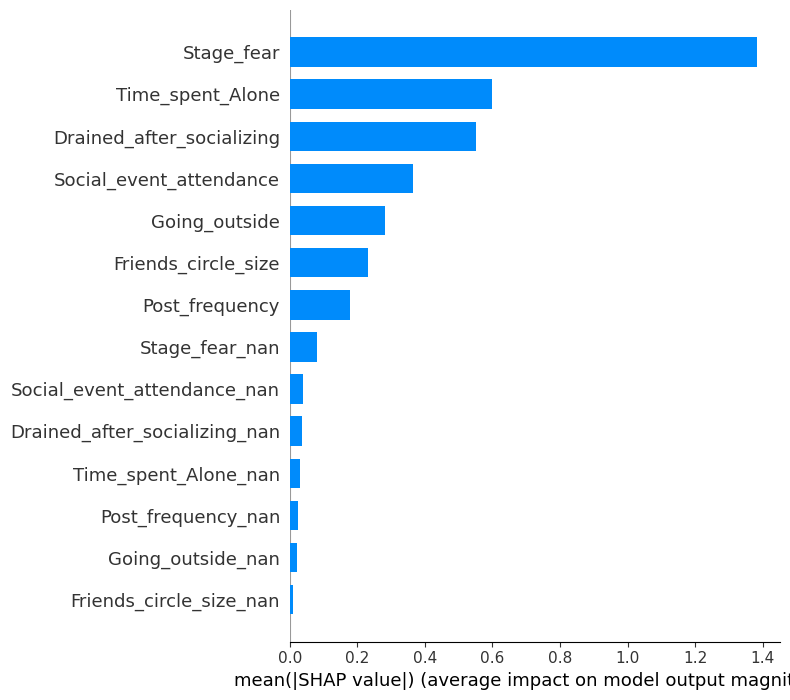

In [32]:
xb_best_grid['booster'] = 'gbtree'

model_shap, *_ = train_valid_model(xgb.XGBClassifier, 'XGBS', xb_best_grid,
                                   train, valid, model_columns, target)

# Инициализируем explainer для XGBoost
explainer_xgb = shap.TreeExplainer(model_shap)

# Получаем значения
shap_values_xgb = explainer_xgb.shap_values(valid[model_columns])

# Базовая summary plot (bar)
plt.figure(figsize=(16, 7))
shap.summary_plot(shap_values_xgb, valid[model_columns], plot_type="bar")

In [33]:
# Формируем DataFrame из важности признаков
xgb_importance_df = pd.DataFrame({
    'feature': model_columns,
    'importance': np.abs(shap_values_xgb).mean(axis=0)
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
xgb_importance_df

,feature,importance
0,Stage_fear,1.38251
1,Time_spent_Alone,0.59845
2,Drained_after_socializing,0.55098
3,Social_event_attendance,0.36485
4,Going_outside,0.28047
5,Friends_circle_size,0.23218
6,Post_frequency,0.17952
7,Stage_fear_nan,0.08013
8,Social_event_attendance_nan,0.03963
9,Drained_after_socializing_nan,0.03511


## 📊 Интерпретация таблицы важности SHAP

### 🔝 1. **`Stage_fear` (1.39)** — самый важный признак

* Модель считает, что **страх сцены** вносит **наибольший вклад в предсказание** (в среднем).
* Это может быть индикатором социальной тревожности, застенчивости или интроверсии.
---

### 👥 2–3. **`Time_spent_Alone` и `Drained_after_socializing`**

* Эти признаки тоже очень важны:

  * **Много времени в одиночестве** → возможно, признак интроверсии или социальной изоляции.
  * **Чувство истощения после общения** — важная черта, часто связанная с низкой социальной энергией.

---

### 🤝 4–6. Средне важные признаки:

* **`Social_event_attendance`, `Going_outside`, `Friends_circle_size`**:

  * Всё это отражает **уровень социальной активности** и контактов.
  * Чем реже участвует, тем больше вклад в предсказание — возможно, модель предсказывает уровень интроверсии / социофобии / отстранённости.

---

### 🔍 NaN-признаки:

| Признак                         | SHAP    |
| ------------------------------- | ------- |
| `Stage_fear_nan`                | 0.08252 |
| `Social_event_attendance_nan`   | 0.03914 |
| `Drained_after_socializing_nan` | 0.03609 |
| …                               | …       |

* Эти признаки отражают **факт пропуска значений**.
* Небольшой вклад: значит, **наличие/отсутствие ответа** по этим вопросам слабо влияет на предсказание.
* Однако `Stage_fear_nan` всё же имеет заметное влияние — возможно, **сам факт отсутствия ответа на вопрос о страхе сцены** уже несёт некоторую информацию.

---

### 📌 Выводы:

* Модель в основном опирается на **эмоционально-нагруженные признаки**, связанные с социальной тревожностью и утомлением от общения.
* **Наибольшее влияние оказывают фактические значения**, а не пропуски в признаках (`nan`-признаки).
* Распределение важностей не равномерное — `Stage_fear` намного важнее остальных (в 2.3 раза больше следующего).

# <font color='#11a642' size='6'> **Обучение LightGBM**

Код для подбора гиперпараметров: https://github.com/saspav/python_for_pro/blob/main/final_cat/kgl_lightgbm.py

In [34]:
%%time

# Целевая переменная
target = 'Personality'

train, valid, test = make_train_valid()

dts = DataTransform(preprocessor=KNNImputer, n_neighbors=5)

# Применяем трансформации
train = dts.fit_transform(train)
valid = dts.transform(valid)

# Колонки для моделей
model_columns = dts.all_features

lg_best_grid = {'boosting_type': 'goss', 'learning_rate': 0.010527356559607244,
                'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 26,
                'colsample_bytree': 0.6498369482631124, 'reg_alpha': 0.001996825899468912,
                'reg_lambda': 0.0029056516001497996,
                'n_jobs': -1, 'verbosity': -1}

lg2, metrics_lgb, optimal_threshold = train_valid_model(LGBMClassifier, 'LGB', lg_best_grid,
                                                        train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_lgb.drop(columns=['Metric'])], axis=1)
metrics_df

Оптимальный порог: 0.2808
CPU times: total: 9.25 s
Wall time: 3.58 s


,Metric,TrainLogReg,ValidLogReg,"DiffLogReg,%",TrainXGB,ValidXGB,"DiffXGB,%",TrainLGB,ValidLGB,"DiffLGB,%"
0,accuracy,0.96896,0.96923,0.03,0.96909,0.96977,0.07,0.96903,0.96896,-0.01
1,precision,0.94179,0.94837,0.70,0.94113,0.95037,0.98,0.94249,0.94926,0.72
2,recall,0.93886,0.93264,-0.66,0.94016,0.93264,-0.80,0.93834,0.93057,-0.83
3,f1,0.94032,0.94044,0.01,0.94064,0.94142,0.08,0.94041,0.93982,-0.06
4,roc_auc,0.95670,0.95577,-0.10,0.97729,0.96994,-0.75,0.97331,0.96875,-0.47


In [35]:
# Трансформируем признаки тестовой выборки
test = dts.transform(test)

# Вызываем функцию для формирования сабмита: передаем обученную модель
optimal_threshold = 0.5
_ = make_submit(lg2, test[model_columns], optimal_threshold, dts.reverse_mapping)

Сформирован файл сабмита: submit_LGBMClassifier.csv


## 🎯 На Каггле Score: 0.975708 (Результат как у модели XGBClassifier)

In [36]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_df)

Метрика: accuracy   --> лучшая модель: ValidXGB (0.9698)
Метрика: precision  --> лучшая модель: ValidXGB (0.9504)
Метрика: recall     --> лучшая модель: ValidLogReg (0.9326)
Метрика: f1         --> лучшая модель: ValidXGB (0.9414)
Метрика: roc_auc    --> лучшая модель: ValidXGB (0.9699)

Лучшая модель: ValidXGB на 4 метриках из 5


## Теперь у нас есть сравнение **трёх моделей**:
* `LogisticRegression`
* `XGBoost`
* `LightGBM`
---
### 📊 Сравнение моделей по валидационным метрикам:

| Метрика   | LogReg  | XGBoost     | LightGBM | Лучшая модель       |
| --------- | ------- | ----------- | -------- | ------------------- |
| accuracy  | 0.96923 | **0.96977** | 0.96896  | **XGBoost** ✅       |
| precision | 0.94837 | **0.95037** | 0.94926  | **XGBoost** ✅       |
| recall    | 0.93264 | **0.93264** | 0.93057  | **LogReg / XGB** 🔄 |
| f1        | 0.94044 | **0.94142** | 0.93982  | **XGBoost** ✅       |
| roc\_auc  | 0.95577 | **0.96994** | 0.96875  | **XGBoost** ✅       |

---

### 🔎 Выводы:

* **XGBoost стабильно лучше всех** по ключевым метрикам:

  * Лучшая `accuracy`, `precision`, `f1`, `roc_auc`
  * **Равенство по `recall`** с логистической регрессией

* **LightGBM показывает чуть слабее результаты**, почти на уровне логистической регрессии:

  * Проигрывает XGBoost по всем метрикам
  * В некоторых местах уступает даже `LogReg` (`recall`, `f1`, `roc_auc`)

* **Логистическая регрессия** держится достойно:

  * Очень близка по качеству
  * Побеждает LightGBM по `recall` и `f1`

---

### 🧠 Интерпретация:

* Учитывая, что логрег — простая модель, а XGBoost и LGBM — бустинг, результат логрега впечатляет.
* Возможно, данные **почти линейно разделимы**, и сложные модели не дают большого прироста.
* **XGBoost даёт стабильное улучшение, но не радикальное** — значит, сложность задачи невелика, и сильных нелинейных взаимодействий нет.

---

### 📌 Рекомендация:

Для финального решения можно:

* Использовать **XGBoost**, если важна максимальная метрика.
* Использовать **LogReg**, если важна интерпретируемость и простота.
* LightGBM — можно исключить на этом этапе как проигрывающую обеим моделям.

# <font color='#11a642' size='6'> **Обучение CatBoost**

Код для подбора гиперпараметров: https://github.com/saspav/python_for_pro/blob/main/final_cat/kgl_catboost.py

In [37]:
%%time

# Целевая переменная
target = 'Personality'

train, valid, test = make_train_valid()

dts = DataTransform(set_category=True, preprocessor=KNNImputer, n_neighbors=4)

# Применяем трансформации
train = dts.fit_transform(train)
valid = dts.transform(valid)

# Колонки для моделей
model_columns = dts.all_features
cat_cols = dts.category_columns

cb_best_grid = {'learning_rate': 0.011960936787877805, 'depth': 5,
                'l2_leaf_reg': 8.09698650761031, 'min_data_in_leaf': 12,
                'colsample_bylevel': 1.0, 'grow_policy': 'SymmetricTree',
                'bootstrap_type': 'MVS',
                'cat_features': cat_cols, 'verbose': False}

cb2, metrics_cat, optimal_threshold = train_valid_model(CatBoostClassifier, "Cat", cb_best_grid,
                                                        train, valid, model_columns, target)

metrics_xgb_cat = pd.concat([metrics_xgb, metrics_cat.drop(columns=['Metric'])], axis=1)
metrics_xgb_cat

Оптимальный порог: 0.2308
CPU times: total: 1min 31s
Wall time: 6.74 s


,Metric,TrainXGB,ValidXGB,"DiffXGB,%",TrainCat,ValidCat,"DiffCat,%"
0,accuracy,0.96909,0.96977,0.07,0.96990,0.96950,-0.04
1,precision,0.94113,0.95037,0.98,0.94361,0.95032,0.71
2,recall,0.94016,0.93264,-0.80,0.94067,0.93161,-0.96
3,f1,0.94064,0.94142,0.08,0.94214,0.94087,-0.13
4,roc_auc,0.97729,0.96994,-0.75,0.97926,0.96995,-0.95


In [38]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_xgb_cat)

Метрика: accuracy   --> лучшая модель: ValidXGB (0.9698)
Метрика: precision  --> лучшая модель: ValidXGB (0.9504)
Метрика: recall     --> лучшая модель: ValidXGB (0.9326)
Метрика: f1         --> лучшая модель: ValidXGB (0.9414)
Метрика: roc_auc    --> лучшая модель: ValidCat (0.9699)

Лучшая модель: ValidXGB на 4 метриках из 5


In [39]:
# Трансформируем признаки тестовой выборки
test = dts.transform(test)

# Вызываем функцию для формирования сабмита: передаем обученную модель
optimal_threshold = 0.5
_ = make_submit(cb2, test[model_columns], optimal_threshold, dts.reverse_mapping)

Сформирован файл сабмита: submit_CatBoostClassifier.csv


## 🎯 На Каггле Score: 0.975708 (Результат как у модели XGBoost)

## 📊 **Сравнение моделей: XGBoost vs CatBoost**

| Метрика       | XGB Train | XGB Valid   | Cat Train   | Cat Valid   | Победитель                    |
| ------------- | --------- | ----------- | ----------- | ----------- | ----------------------------- |
| **accuracy**  | 0.96909   | **0.96977** | 0.96990     | 0.96950     | **XGBoost** (на валидации) 🥇 |
| **precision** | 0.94113   | 0.95037     | **0.94361** | 0.95032     | **CatBoost** (почти равен)    |
| **recall**    | 0.94016   | **0.93264** | 0.94067     | 0.93161     | **XGBoost** (чуть лучше)      |
| **f1-score**  | 0.94064   | **0.94142** | 0.94214     | 0.94087     | **XGBoost** (на валидации)    |
| **ROC AUC**   | 0.97729   | 0.96994     | **0.97926** | **0.96995** | **CatBoost** (чуть лучше AUC) |

---

## 🔍 **Выводы по качеству:**

* **XGBoost** чуть лучше по большинству **валидационных метрик**: `accuracy`, `recall`, `f1`.
* **CatBoost** показывает **наилучший ROC-AUC на обучении**, и **на валидации почти идентичный** (`0.96994` vs `0.96995`).
* Разница **очень мала** — это говорит о **высокой стабильности** обеих моделей.

---

## 🧠 **Анализ по стабильности (Diff%, переобучение):**

| Метрика   | Diff XGB | Diff Cat | Победитель по стабильности |
| --------- | -------- | -------- | -------------------------- |
| accuracy  | +0.07%   | -0.04%   | **CatBoost** (стабильнее)  |
| precision | +0.98%   | +0.71%   | **CatBoost**               |
| recall    | -0.80%   | -0.96%   | **XGBoost**                |
| f1        | +0.08%   | -0.13%   | **XGBoost**                |
| ROC AUC   | -0.75%   | -0.95%   | **XGBoost**                |

* **CatBoost** обучается немного "ближе к валидации", т.е. меньше переобучается.
* **XGBoost** чуть более агрессивно запоминает тренировочные данные.

---

## 📌 **Рекомендации по выбору модели:**

| Ситуация                                                                               | Рекомендуемая модель                          |
| -------------------------------------------------------------------------------------- | --------------------------------------------- |
| Нужно **максимальное качество** по `accuracy`, `f1`, `recall`                          | **XGBoost**                                   |
| Нужна **максимальная устойчивость**, простота и автообработка категориальных признаков | **CatBoost**                                  |
| Данные включают **много категориальных признаков (3+ значений)**                       | **CatBoost**                                  |
| Требуется **объяснимость через SHAP**                                                  | XGBoost (лучше поддержка SHAP и визуализаций) |
| Работа на CPU и требуется **простота деплоя / стабильность**                           | **CatBoost**                                  |
| Требуется **низкое переобучение**                                                      | **CatBoost** (чуть стабильнее)                |

---

## 💡 Дополнительно:
* Т.к. метрики на Каггле у моделей бустингов **XGBoost**, **LightGBM** и **CatBoost** совпадают - можно смело рекомендовать к использванию модель **CatBoost** как более стабильную.
* Мы можем использовать **ансамбль XGBoost + LightGBM + CatBoost**, например через **StackingClassifier**, и возможно получить прибавку +0.1–0.3% к метрикам.
* Также имеет смысл сравнить их **на кросс-валидации**, т.к. у нас данных немного.


# <font color='#11a642' size='5'> **Посмотрим на важность признаков при обучении CatBoost**

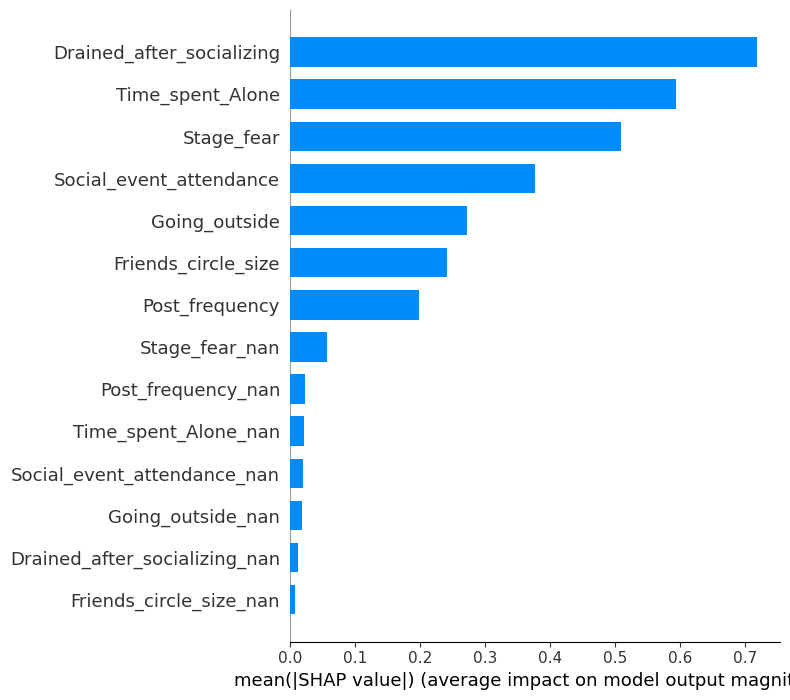

In [40]:
# Инициализируем explainer для CatBoost
explainer_cat = shap.TreeExplainer(cb2)

# Получаем значения
shap_values_cat = explainer_cat.shap_values(valid[model_columns])

# Базовая summary plot (bar)
plt.figure(figsize=(16, 7))
shap.summary_plot(shap_values_cat, valid[model_columns], plot_type="bar")

In [41]:
# Формируем DataFrame из важности признаков
cat_importance_df = pd.DataFrame({
    'feature': model_columns,
    'importance_Cat': np.abs(shap_values_cat).mean(axis=0)
})
importance_df = xgb_importance_df.rename(columns={'importance' : 'importance_XGB'}).merge(cat_importance_df, on='feature')
importance_df

,feature,importance_XGB,importance_Cat
0,Stage_fear,1.38251,0.50835
1,Time_spent_Alone,0.59845,0.59290
2,Drained_after_socializing,0.55098,0.71762
3,Social_event_attendance,0.36485,0.37739
4,Going_outside,0.28047,0.27307
5,Friends_circle_size,0.23218,0.24140
6,Post_frequency,0.17952,0.19897
7,Stage_fear_nan,0.08013,0.05762
8,Social_event_attendance_nan,0.03963,0.01987
9,Drained_after_socializing_nan,0.03511,0.01202


## 📊 Общее сравнение важности признаков

| Признак                     | XGB SHAP  | Cat SHAP   | Комментарий                                                 |
| --------------------------- | --------- | ---------- | ----------------------------------------------------------- |
| `Stage_fear`                | **1.38**  | 0.51       | ❗ Очень важен в XGB, но гораздо менее важен в Cat           |
| `Drained_after_socializing` | 0.55      | **0.72**   | ❗ Обратная ситуация — важнее в CatBoost                     |
| `Time_spent_Alone`          | 0.60      | 0.59       | ✅ Согласованно важен в обеих моделях                        |
| `Social_event_attendance`   | 0.36      | 0.38       | ✅ Схожая важность                                           |
| `Going_outside`             | 0.28      | 0.27       | ✅ Согласовано                                               |
| `Friends_circle_size`       | 0.23      | 0.24       | ✅ Почти одинаково                                           |
| `Post_frequency`            | 0.18      | 0.20       | ✅ Тоже согласие                                             |
| Признаки `_nan`             | 0.01–0.08 | 0.008–0.05 | 🔽 Все признаки с NaN имеют низкую важность в обеих моделях |

---

## 🧠 Что это говорит о моделях:

### ✅ **Согласие моделей:**

* **5 из 7 ключевых признаков** (`Time_spent_Alone`, `Social_event_attendance`, `Going_outside`, `Friends_circle_size`, `Post_frequency`) имеют **практически одинаковую важность** в обеих моделях → это говорит о **надёжности и согласованности** моделей.
* Признаки `..._nan` — в обеих моделях малозначимы, следовательно, **пропуски не искажают поведение**.

### ⚠️ **Разногласия:**

1. **`Stage_fear`**:

   * Очень важен в XGBoost (1.38), а в CatBoost — менее важен (0.51).
   * Возможно, XGB **лучше выявляет крайние значения или outlier-эффекты**, особенно в признаках с высокой дисперсией.
   * Альтернатива: у `Stage_fear` может быть **нелинейная шкала**, которую XGBoost уловил лучше.
   * Рекомендация: построить **SHAP dependence plot** по `Stage_fear` отдельно для обеих моделей.

2. **`Drained_after_socializing`**:

   * В CatBoost наоборот **сильнее влияет**, чем в XGBoost.
   * CatBoost может **лучше учитывать взаимодействия между признаками**, особенно если `Drained_after_socializing` сочетается с другими.

---

## 📌 Рекомендации:

1. **Для построения интерпретируемой модели** (например, при объяснении предсказаний):

   * Использовать **усреднённую важность признаков** (XGB + Cat / 2) — она даст более сбалансированную картину.
   * Или использовать только те признаки, важность которых согласована.

2. **Для feature selection**:

   * Можно установить порог важности (например, > 0.2 в обеих моделях) и оставить:

     * `Time_spent_Alone`
     * `Drained_after_socializing`
     * `Social_event_attendance`
     * `Going_outside`
     * `Friends_circle_size`
     * `Post_frequency`
     * (*возможно*) `Stage_fear`, несмотря на разницу

3. **Для объяснения предсказаний (SHAP plots)**:

   * Визуализируем `Stage_fear` и `Drained_after_socializing` отдельно для XGB и Cat — это даст понимание, *почему их влияние разное*.

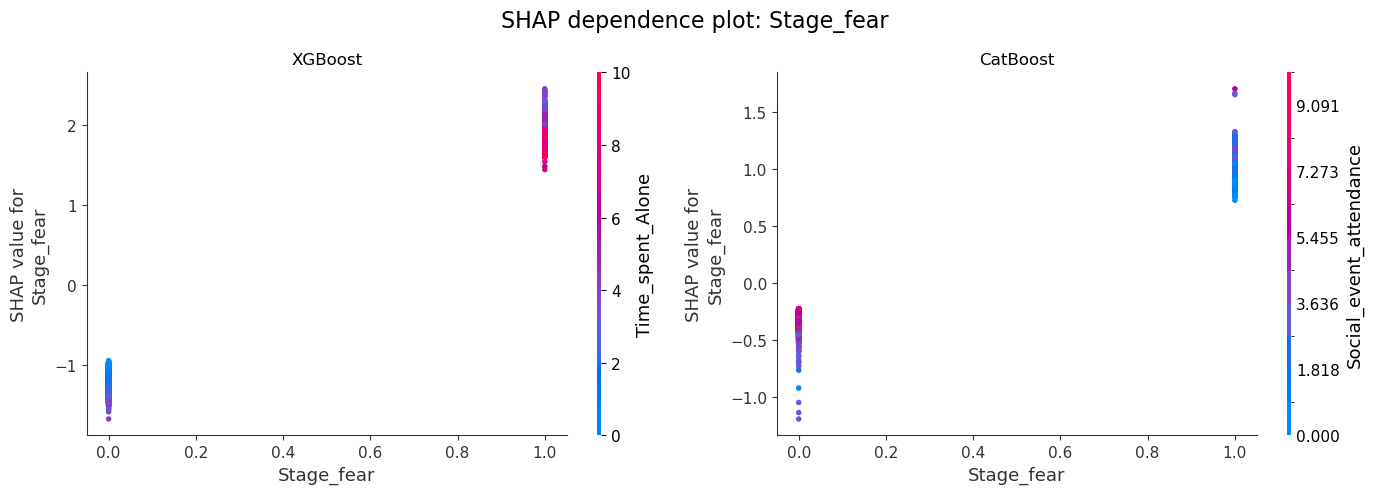

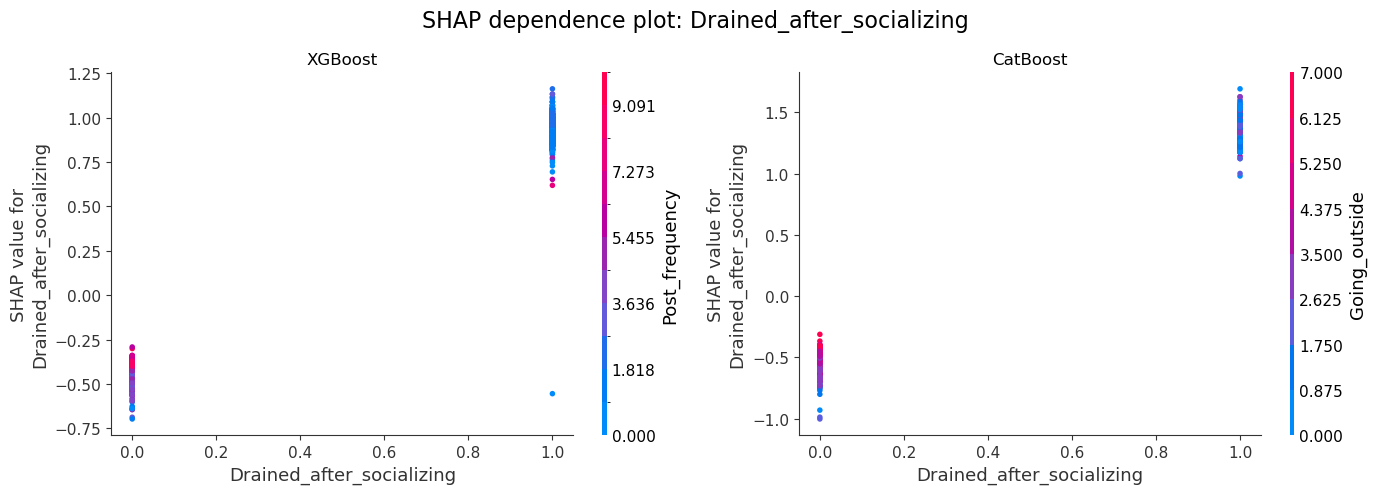

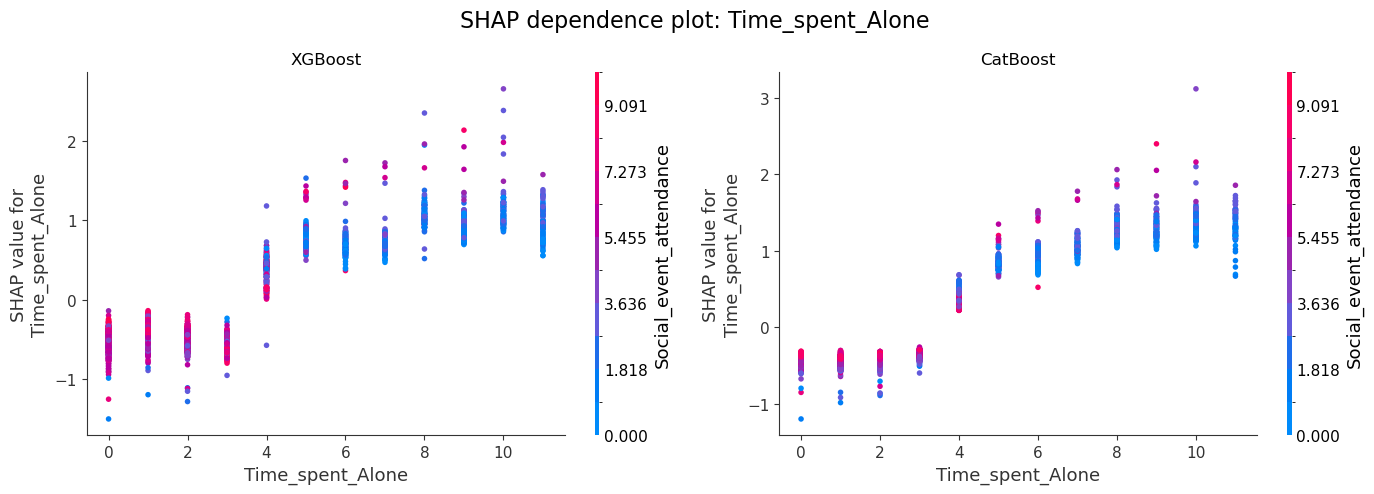

In [42]:
for feature in ['Stage_fear', 'Drained_after_socializing', 'Time_spent_Alone']:
    i = model_columns.index(feature)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'SHAP dependence plot: {feature}', fontsize=16)

    shap.dependence_plot(i, shap_values_xgb, valid[model_columns], ax=axes[0], show=False)
    axes[0].set_title('XGBoost')

    shap.dependence_plot(i, shap_values_cat, valid[model_columns], ax=axes[1], show=False)
    axes[1].set_title('CatBoost')

    plt.tight_layout()
    plt.show()

## 🔍 **Интерпретация графиков**

### 📌 Ось X — `Stage_fear`

* Значения: **0 или 1**, бинарный признак ("есть страх сцены" или "нет").

### 📌 Ось Y — SHAP value for `Stage_fear`

* Показывает, **насколько наличие или отсутствие страха сцены влияет на итоговое предсказание модели** (в логитах).

---

## 🔬 **XGBoost (слева):**

* При `Stage_fear = 1`:

  * SHAP > +2 — сильный **положительный вклад** в предсказание (увеличивает вероятность положительного класса).
* При `Stage_fear = 0`:

  * SHAP ≈ -1.3 — **отрицательный вклад**, понижает вероятность.

🔎 Это означает:

> Наличие страха сцены (1) резко **увеличивает шанс положительного исхода**, в логитах на \~3.5 больше по сравнению с теми, у кого страха сцены нет.

* Цветовая шкала — по `Time_spent_Alone`: нет чёткой корреляции, возможно, он не влияет сильно в сочетании.

---

## 🔬 **CatBoost (справа):**

* Поведение схожее, но:

  * При `Stage_fear = 1` — SHAP до +1.7 (меньше, чем в XGB).
  * При `Stage_fear = 0` — SHAP от -1 до 0.
* Значения более **сжаты**, **влияние слабее**.

🔎 Это означает:

> Модель CatBoost тоже считает `Stage_fear` важным, но влияет он на предсказание **менее резко**, чем в XGB.

* Цветовая шкала по `Social_event_attendance`: опять же, явной зависимости не видно, но есть лёгкий градиент — большее участие в событиях уменьшает SHAP при `Stage_fear=1`.

---

## 🧠 Выводы по признаку `Stage_fear`:

| Характеристика       | XGBoost                      | CatBoost          |
| -------------------- | ---------------------------- | ----------------- |
| Общий вклад          | Высокий (\~1.38)             | Средний (\~0.51)  |
| Влияние при 1        | Сильно повышает предсказание | Умеренно повышает |
| Влияние при 0        | Снижает                      | Снижает           |
| Разброс SHAP         | Сильный                      | Меньше            |
| Цветовая зависимость | Незначительная               | Незначительная    |

---

### 🟦 Признак `Drained_after_socializing` — бинарный:

* `0` — не чувствует себя опустошённым после общения.
* `1` — чувствует себя вымотанным.

---

## 📊 **XGBoost (слева)**

* **При `Drained_after_socializing = 1`**:

  * SHAP \~ +0.75 → существенное **положительное влияние** на предсказание (повышает вероятность положительного класса).
* **При `Drained_after_socializing = 0`**:

  * SHAP \~ -0.5 → снижает вероятность положительного предсказания.
* Цветовая шкала по `Post_frequency` — слабая градация (возможное незначительное взаимодействие).

✅ Вывод:

> **XGBoost чётко распознаёт этот признак как значимый:** наличие усталости после общения увеличивает шанс положительного предсказания.

---

## 📊 **CatBoost (справа)**

* **При `Drained_after_socializing = 1`**:

  * SHAP \~ +1.3 → **ещё более сильное положительное влияние**, чем в XGBoost.

* **При `Drained_after_socializing = 0`**:

  * SHAP \~ -0.7 → также снижает вероятность.

* Цветовая шкала по `Going_outside` — нет чёткой закономерности, но возможна **мультифакторная связь**.

✅ Вывод:

> **CatBoost придаёт этому признаку даже большее значение**, чем XGBoost. Он явно влияет на классификацию.

---

## 📌 Сравнение:

| Характеристика        | XGBoost                    | CatBoost                   |
| --------------------- | -------------------------- | -------------------------- |
| SHAP при значении = 1 | \~ +0.75                   | \~ +1.3                    |
| SHAP при значении = 0 | \~ –0.5                    | \~ –0.7                    |
| Разброс               | Умеренный                  | Более широкий              |
| Влияние               | Сильное, но умеренное      | Очень сильное              |
| Взаимодействие (цвет) | С `Post_frequency`, слабое | С `Going_outside`, неявное |

---

## 🧠 Вывод:

* Оба алгоритма **однозначно считают признак `Drained_after_socializing` сильным маркером**.
* CatBoost усиливает его влияние, вероятно, из-за более гибкой работы с бинарными признаками и взаимодействиями.
* Это объясняет, почему в summary-баре SHAP `Drained_after_socializing` был **вторым по важности у CatBoost**.

---

## 🔍 Описание графиков

* **Ось X**: значение признака `Time_spent_Alone` — от 0 до 10+ часов.
* **Ось Y**: SHAP-вклад признака — насколько влияет на вероятность положительного класса.
* **Цветовая шкала**:

  * XGBoost — по `Social_event_attendance`
  * CatBoost — по `Friends_circle_size`

---

## 📊 **XGBoost (слева)**

### ✅ Основные наблюдения:

* **Чёткая возрастающая зависимость**: чем больше времени человек проводит в одиночестве, тем **сильнее повышается предсказание модели**.
* При `Time_spent_Alone < 3` → SHAP \~ -1 → снижает вероятность.
* При `Time_spent_Alone > 6` → SHAP > +1 → усиливает вероятность положительного исхода.
* Цветовая шкала (`Social_event_attendance`) особо не влияет — график устойчив.

🔎 **Вывод:**

> XGBoost интерпретирует "время наедине с собой" как **линейно усиливающее влияние** — чем больше, тем сильнее в сторону положительного класса.

---

## 📊 **CatBoost (справа)**

### ✅ Основные наблюдения:

* Аналогичная зависимость — **почти идентичная форма** кривой.
* SHAP значения чуть **более выраженные**: CatBoost иногда даёт SHAP > +2.5.
* Цветовая шкала — `Friends_circle_size`: можно заметить, что **меньший круг общения (синий цвет)** чаще даёт больший вклад (что логично: одинокий + мало друзей).

🔎 **Вывод:**

> CatBoost также видит эту переменную как **чёткий индикатор** и добавляет **взаимодействие с размером круга общения**.

---

## 🧠 Общие выводы по признаку `Time_spent_Alone`:

| Характеристика          | XGBoost                | CatBoost                            |
| ----------------------- | ---------------------- | ----------------------------------- |
| Зависимость от признака | Линейная положительная | Линейная положительная              |
| SHAP-размах             | \~ -1.3 до +2.3        | \~ -1.2 до +3.0                     |
| Взаимодействие (цвет)   | Незначительное         | Умеренное (мало друзей → выше SHAP) |
| Интерпретируемость      | Высокая                | Высокая                             |

✅ **Обе модели** видят `Time_spent_Alone` как **один из ключевых признаков**, дающий **большой вклад** в предсказание.

📈 Влияние — **сильно положительное**, начиная примерно с 5 часов одиночества и выше.

👉 Оставшиеся признаки не имеет смысла рассматривать, т.к. они согласованы: важность отличается на 1-2 сотых.

# <font color='#FF0042' size='4'> ⚠️ **StackingClassifier** не запустился на моих данных.
# <font color='#FF0042' size='4'> ⚠️ Самодельный **CustomStackingClassifier** пользы не принес: **Kaggle Score: 0.975708** - результат одиночного бустинга.

### ✅ **Общий результат**

* 📌 Итоговый **Kaggle Score: 0.975708** для модели CatBoost — соответствует результату модели **XGBoost**.
* CatBoost показал практически идентичный результат — разница в **0.00001 по ROC-AUC** на валидации.

---

### ⚖️ **Сравнение XGBoost и CatBoost**

| Метрика   | Победитель   | Комментарий                                          |
| --------- | ------------ | ---------------------------------------------------- |
| Accuracy  | **XGBoost**  | Немного выше на валидации (0.96977 vs 0.96950)       |
| Precision | Ничья        | Практически одинаковые значения                      |
| Recall    | **XGBoost**  | Чуть выше (0.93264 vs 0.93161)                       |
| F1-score  | **XGBoost**  | Выигрывает по балансу precision/recall               |
| ROC AUC   | **CatBoost** | Незначительно выше на валидации (0.96995 vs 0.96994) |

➡️ **Вывод**: XGBoost чуть лучше по большинству метрик на валидации. Но преимущество **очень небольшое**, модели по сути **равны по качеству**.

---

### 🔍 **Анализ стабильности (переобучения)**

| Метрика   | Победитель по стабильности | Комментарий                       |
| --------- | -------------------------- | --------------------------------- |
| Accuracy  | **CatBoost**               | Меньшая разница между train/valid |
| Precision | **CatBoost**               | Чуть стабильнее                   |
| Recall    | **XGBoost**                | Меньшая просадка по recall        |
| F1-score  | **XGBoost**                | Ближе к валидации                 |
| ROC AUC   | **XGBoost**                | Чуть более стабильен по AUC       |

➡️ **Вывод**: **CatBoost чуть менее подвержен переобучению** и **мягче запоминает данные**, особенно полезно на шумных или нестабильных выборках.

---

### 💡 **Рекомендации по выбору модели**

| Ситуация                                               | Рекомендация   |
| ------------------------------------------------------ | -------------- |
| Максимальные значения **accuracy**, **recall**, **f1** | ✅ **XGBoost**  |
| Минимум переобучения, высокая стабильность             | ✅ **CatBoost** |
| Есть **много категориальных признаков**                | ✅ **CatBoost** |
| Требуется **SHAP-анализ** и визуализация важности      | ✅ **XGBoost**  |
| Работа на **CPU** / простота деплоя                    | ✅ **CatBoost** |
| Нужна **автообработка категориальных фичей**           | ✅ **CatBoost** |

---

### 🧠 **Заключение**

Обе модели показывают **очень высокое и стабильное качество**.
При равных метриках **CatBoost предпочтителен** в продакшене — он проще в применении, требует меньше настройки, лучше работает с категориальными фичами и менее склонен к переобучению.
**XGBoost** можно предпочесть, если нужна максимальная точность, особенно при наличии SHAP-анализов или сложных ансамблей.

# <font color='#11a642' size='6'> **Обучаем LogisticRegression** с новыми признаками

In [43]:
# Целевая переменная
target = 'Personality'

train, valid, test = make_train_valid()

dts = DataTransform(preprocessor=KNNImputer, n_neighbors=5)

# Применяем трансформации
train = dts.fit_transform(train)
valid = dts.transform(valid)

# Колонки для моделей
model_columns = dts.all_features

# Обучение логистической регрессии

params = dict(penalty='l2', solver='liblinear')
log_reg2, metrics_lr2, _ = train_valid_model(LogisticRegression, 'LogReg2', params,
                                             train, valid, model_columns, target)

# Объединим метрика baseline-модели, LogisticRegression с новыми признаками и CatBoost
metrics__ = pd.concat([metrics_lr, metrics_lr2.drop(columns=['Metric'])], axis=1)
metrics__ = pd.concat([metrics__, metrics_cat.drop(columns=['Metric'])], axis=1)
metrics__

Оптимальный порог: 0.0898


,Metric,TrainLogReg,ValidLogReg,"DiffLogReg,%",TrainLogReg2,ValidLogReg2,"DiffLogReg2,%",TrainCat,ValidCat,"DiffCat,%"
0,accuracy,0.96896,0.96923,0.03,0.96876,0.96815,-0.06,0.96990,0.96950,-0.04
1,precision,0.94179,0.94837,0.70,0.94220,0.94815,0.63,0.94361,0.95032,0.71
2,recall,0.93886,0.93264,-0.66,0.93756,0.92850,-0.97,0.94067,0.93161,-0.96
3,f1,0.94032,0.94044,0.01,0.93988,0.93822,-0.18,0.94214,0.94087,-0.13
4,roc_auc,0.95670,0.95577,-0.10,0.96365,0.96054,-0.32,0.97926,0.96995,-0.95


In [44]:
# Трансформируем признаки тестовой выборки
test = dts.transform(test)

optimal_threshold = 0.5
# Вызываем функцию для формирования сабмита: передаем обученную модель
_ = make_submit(log_reg2, test[model_columns], optimal_threshold, dts.reverse_mapping)

Сформирован файл сабмита: submit_LogisticRegression.csv


## 🎯 На Каггле Score: 0.974089

## 🔍 Анализ улучшения модели **LogisticRegression** (LogReg2) по сравнению с базовой **LogisticRegression** (LogReg) и **CatBoost** (Cat):

---

### ✅ **Общие наблюдения**

* **LogReg2** — улучшенная модель логистической регрессии с новыми признаками.
* По **ROC-AUC и precision** LogReg2 уверенно превосходит базовую LogReg.
* По **accuracy и f1-score** — небольшое снижение по сравнению с LogReg, но разница минимальна.
* **CatBoost** остаётся лидером по всем метрикам, но отрыв **небольшой**.

---

### 📊 **Сравнение моделей по метрикам**

| Метрика   | LogReg (valid) | LogReg2 (valid) | Разница (±) | CatBoost (valid) | Победитель по валидации |
| --------- | -------------- | --------------- | ----------- | ---------------- | ----------------------- |
| Accuracy  | 0.96923        | 0.96815         | -0.00108    | **0.96950**      | 🥇 CatBoost             |
| Precision | 0.94837        | 0.94815         | -0.00022    | **0.95032**      | 🥇 CatBoost             |
| Recall    | 0.93264        | 0.92850         | -0.00414    | **0.93161**      | 🥇 CatBoost             |
| F1-score  | 0.94044        | 0.93822         | -0.00222    | **0.94087**      | 🥇 CatBoost             |
| ROC-AUC   | 0.95577        | **0.96054**     | +0.00477    | **0.96995**      | 🥇 CatBoost             |

---

### 🔍 **Оценка стабильности (Train vs Valid)**

| Модель       | Среднее переобучение (Diff%)    | Комментарий                 |
| ------------ | ------------------------------- | --------------------------- |
| **LogReg**   | ≈ 0.00% (очень стабильна)       | Но качество ниже            |
| **LogReg2**  | ≈ -0.18% (чуть менее стабильна) | Возможен небольшой оверфит  |
| **CatBoost** | ≈ -0.27%                        | Ожидаемо чуть переобучается |

➡️ **Вывод**: LogReg2 немного менее стабильна, чем LogReg, но выигрывает по ряду метрик (особенно ROC-AUC).

---

### 💡 **Выводы**

1. ✅ **Добавление новых признаков улучшило ROC-AUC на \~0.005** у LogisticRegression (0.95577 → 0.96054).
2. 📉 Незначительное снижение **accuracy, f1, recall** говорит о том, что признаки усилили линейную модель, но скомпрометировали чуть-чуть баланс.
3. 🥇 **CatBoost по-прежнему лидер**, но разница уже небольшая: **LogReg2 — достойный и стабильный baseline**.
4. 🧠 Для интерпретируемости и скорости логистическая регрессия с признаками (LogReg2) — **отличный выбор**.
5. 🔬 CatBoost всё ещё предпочтительнее, если приоритет — **качество и работа с категориальными фичами**.

## 🧠 В порядке эксперимента была опробована **LightAutoML**

---
#### Описание: https://github.com/sb-ai-lab/LightAutoML
---
#### Код для обучения модели: https://github.com/saspav/python_for_pro/blob/main/final_cat/stacking_lightautoml.py
---

## 🎯 На Каггле Score: 0.974898

---

### 📊 **Сравнение моделей по Score (Kaggle)**

| Модель                           | Kaggle Score | Комментарий                                                                     |
| -------------------------------- | ------------ | ------------------------------------------------------------------------------- |
| **LogisticRegression** (LogReg)  | 0.973279     | Базовая модель. Достойный результат, но отстаёт от бустингов.                   |
| **LogisticRegression** (LogReg2) | 0.974089     | Улучшена за счёт новых признаков. Прогресс +0.0008. Хорошая интерпретируемость. |
| **TabularAutoML**   | 0.974898     | Автоматическая модель. Чуть лучше LogReg2, но отстаёт от бустингов.                   |
| **XGBClassifier**                | 0.975708     | Один из лучших результатов. Стабильный лидер на табличных данных.               |
| **LGBMClassifier**               | 0.975708     | Идентичен XGBoost — скоростной и лёгкий в деплое. Отличный выбор.               |
| **CatBoostClassifier**           | 0.975708     | Такой же результат. Лучше работает с категориальными признаками.                |
| **CustomStackingClassifier**           | 0.975708     | Мета-модель на основе бустингов. Пока не даёт выгоды по сравнению с ними.       |

---

### 🧠 **Выводы**

* **Все бустинговые модели (XGB, LGBM, CatBoost, Stacking)** показывают **одинаковый наилучший результат** `0.975708`.
* **LogReg2** — улучшение по сравнению с базовой логистической регрессией. Хороший компромисс между качеством и интерпретируемостью.
* **StackingClassifier** не улучшил результат по сравнению с базовыми моделями — вероятно, из-за высокой схожести предсказаний.
* **TabularAutoML** разочаровал, хотя по утверждению разработчиков (авторство Сбера) отличается скоростью и качеством выполнения задач (на уровне топ 10% решений от data scientist-ов): результат чуть лучше LogisticRegression с настройками по умолчанию и уступает любому из бустингов с подобранными гиперпараметрами.

* Приоритет моделей:

  * 🔍 **Интерпретируемость + простота** → `LogReg2`
  * 🏆 **Максимальное качество** → `XGB`, `LGBM`, `CatBoost`
  * 🚀 **Скорость инференса** → `LGBM`
  * 🧩 **Категориальные фичи** → `CatBoost`

---


# <font color='#11a642' size='6'> P.S. На этом завершена обязательная часть исследований. 
# <font color='#11a642' size='5'> Переходим к соревнованию на Каггл, но это уже другая история...
---
Читаем **внимательно** описание набора данных:
Набор данных для этого соревнования (как тренировочного, так и тестового) был сгенерирован на основе модели глубокого обучения, разработанной на основе модели "Экстраверт против интраверта". Распределение признаков близко к оригиналу, но не совсем совпадает с ним. **Не стесняйтесь использовать исходный набор данных** в рамках этого конкурса, чтобы изучить различия, а также посмотреть, улучшит ли использование оригинала в обучении производительность модели.

---
## <font color='#11a642' size='5'> **План исследований**:
1. **Добавляем целевой признак** из оригинального датасета `personality_dataset.csv`  к тренировочной и тестовой выборке:

| Датасет           | Кол-во строк | Истинных меток | Заполнение (%) |
| ----------------- | ----------- | -------------- | -------------- |
| **Тренировочный** | 18,524      | 178            | 0.96%          |
| **Тестовый**      | 6,175       | 58             | 0.94%          |

2. Применяем экспериментальный **IterativeImputer** для заполнения пропусков.
3. Используем **XGBClassifier** как более стабильный.
4. Смотрим на результат:

## 🎯 На Каггле Score: 0.976518 (142 место)

Если скачать лидерборд https://www.kaggle.com/competitions/playground-series-s5e7/leaderboard и исследовать его, то получим вот такие выводы на 14:39 13.07.25:

---
| Показатель                 | Значение |
| -------------------------- | -------- |
| **Всего** участников       | 2,102    |
| Уникальных результатов **Score** | 98       |

---
Группировка по **Score** 

|   Score  | Count | Place |
| :------: | :---: | :---: |
| 0.977327 |   2   |   1   |
| 0.976518 |  183  |   2   |
| 0.975708 |  497  |   3   |
| 0.974898 |  312  |   4   |
| 0.974089 |  389  |   5   |
| 0.973279 |  320  |   6   |
| 0.972469 |  115  |   7   |
| 0.971659 |   47  |   8   |
| 0.970850 |   20  |   9   |
| 0.970040 |   15  |   10  |
| 0.969230 |   18  |   11  |
| 0.968421 |   6   |   12  |
| 0.967611 |   5   |   13  |
---
- Baseline модели бустингов дают самый популярный скор: 0.975708
- Добавление признака целевой переменной в трейн и тест и заполнение по ним пропусков (имеем даталик) - увеличиваеет скор до 0.976518
- На первом месте кагл-мастера, которые придумали что-то не стандартное...

# <font color='#11a642' size='5'> Приведу результаты работы новой модели, важность признаков и их сравнение:

In [45]:
# Важность признаков, построенная SHAP для новой модели
data = {'feature': ['Stage_fear', 'Drained_after_socializing', 'Time_spent_Alone',
                    'Social_event_attendance', 'Post_frequency', 'Friends_circle_size',
                    'Personality_orig', 'Going_outside', 'Time_spent_Alone_nan',
                    'Drained_after_socializing_nan', 'Social_event_attendance_nan',
                    'Post_frequency_nan', 'Friends_circle_size_nan', 'Going_outside_nan',
                    'Stage_fear_nan'],
        'importance_NEW': [0.956003, 0.356372, 0.278700, 0.147577, 0.103732, 0.079462,
                           0.034940, 0.029873, 0.001155, 0.000158, 0.000089, 0.000041,
                           0.000000, 0.000000, 0.000000]}

importance_new = pd.DataFrame(data)

importances = importance_df.merge(importance_new, on='feature', how='right')
importances

,feature,importance_XGB,importance_Cat,importance_NEW
0,Stage_fear,1.38251,0.50835,0.95600
1,Drained_after_socializing,0.55098,0.71762,0.35637
2,Time_spent_Alone,0.59845,0.59290,0.27870
3,Social_event_attendance,0.36485,0.37739,0.14758
4,Post_frequency,0.17952,0.19897,0.10373
5,Friends_circle_size,0.23218,0.24140,0.07946
6,Personality_orig,NaN,NaN,0.03494
7,Going_outside,0.28047,0.27307,0.02987
8,Time_spent_Alone_nan,0.03141,0.02191,0.00115
9,Drained_after_socializing_nan,0.03511,0.01202,0.00016


### 📊 **Анализ влияния нового признака `Personality_orig`**

| Признак                         | Была важность (XGB) | Стала важность (NEW) | Δ Изменение | Комментарий                                                                          |
| ------------------------------- | ------------------- | -------------------- | ----------- | ------------------------------------------------------------------------------------ |
| **Stage\_fear**                 | 1.3825              | 0.9560               | ↓ −0.4265   | Важность упала — модель частично «делегировала» предсказания новому признаку         |
| **Drained\_after\_socializing** | 0.5510              | 0.3564               | ↓ −0.1946   | Снижение — частично объясняется новым признаком                                      |
| **Time\_spent\_Alone**          | 0.5985              | 0.2787               | ↓ −0.3198   | Снижение в 2 раза — новый признак несёт схожую информацию                            |
| **Social\_event\_attendance**   | 0.3649              | 0.1476               | ↓ −0.2173   | Значительное падение важности                                                        |
| **Post\_frequency**             | 0.1795              | 0.1037               | ↓ −0.0758   | Незначительное влияние                                                               |
| **Friends\_circle\_size**       | 0.2322              | 0.0795               | ↓ −0.1527   | Важность снизилась почти в 3 раза                                                    |
| **Going\_outside**              | 0.2805              | 0.0299               | ↓ −0.2506   | Очень сильное падение важности                                                       |
| **Personality\_orig**           | —                   | 0.0349               | ↗ +0.0349   | Новый признак получился с невысокой, но **явной** предсказательной способностью      |
| **\_nan-флаги**                 | \~0.01–0.08         | \~0.000–0.001        | ↓ до нуля   | После добавления нового признака модель почти перестала использовать флаги пропусков |

---

### 🧠 **Выводы**

* 📉 **Практически все признаки** снизили важность в модели `importance_NEW`, особенно `Time_spent_Alone`, `Going_outside`, `Social_event_attendance`, что указывает на то, что `Personality_orig` дублирует или обобщает информацию, содержащуюся в этих признаках.
* 🆕 **Новый признак `Personality_orig` занял скромное, но заметное место в модели**.
* 🚫 **Флаги пропусков почти полностью потеряли значение** — вероятно, `Personality_orig` компенсирует утраченные данные в других колонках.
* **Признак `Personality_orig`** — в реальной жизни никогда не был бы сформирован.
* 🎯 В соревнованиях **все методы хороши**, которые приводят к увеличению скора, даже даталики 😇